## Finding Replications based on KDE plus Z score

In [87]:
"""
Project Similarity Detector
==========================
This module contains the core ProjectSimilarityDetector class for detecting similar projects
using embeddings with two complementary methods:
1. Sector-Adjusted Z-Score of Minimum Distance
2. Kernel Density Estimation (KDE)
"""

import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
import umap
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import pickle
import random
from scipy.spatial.distance import cosine
from scipy.stats import iqr

class ProjectSimilarityDetector:
    """
    A class to detect similar projects using embeddings with two complementary methods:
    1. Sector-Adjusted Z-Score of Minimum Distance
    2. Kernel Density Estimation (KDE)
    """
    def __init__(self, umap_dim=15, z_score_threshold=2.0, kde_percentile=70, use_project_level=True):
        """
        Initialize the detector with parameters.
        
        Parameters:
        -----------
        umap_dim : int
            Number of dimensions to reduce to for KDE (default: 15)
        z_score_threshold : float
            Z-score threshold for flagging similar projects (default: 2.0)
        kde_percentile : int
            Percentile threshold for KDE density (default: 70)
        use_project_level : bool
            If True, use project-level comparisons instead of chunk-level (default: True)
        """
        self.umap_dim = umap_dim
        self.z_score_threshold = z_score_threshold
        self.kde_percentile = kde_percentile
        self.use_project_level = use_project_level
        self.sector_stats = {}
        self.sector_umap_models = {}
        self.sector_kde_models = {}
        self.sector_density_thresholds = {}
        
    def precompute_sector_statistics_project_level(self, df, embedding_col='embedding'):
        """
        Precompute pairwise distances statistics for each sector at the project level.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            DataFrame containing project data with embeddings
        embedding_col : str
            Name of the column containing embeddings
        """
        print("Precomputing sector statistics at project level...")
        
        # Check if 'data_id' column exists
        if 'data_id' not in df.columns:
            print("Error: 'data_id' column not found. Cannot aggregate at project level.")
            return
        
        for sector in tqdm(df['sector'].unique()):
            sector_df = df[df['sector'] == sector]
            
            # Skip sectors with too few projects
            unique_projects = sector_df['data_id'].nunique()
            if unique_projects < 5:
                print(f"  Skipping sector '{sector}' - not enough unique projects ({unique_projects})")
                continue
                
            print(f"  Computing project-level statistics for sector '{sector}' ({unique_projects} unique projects)...")
            
            # First, aggregate embeddings by project (data_id)
            grouped = sector_df.groupby('data_id')
            
            # Calculate median embedding for each project
            project_embeddings = {}
            for data_id, group in grouped:
                embeddings_array = np.vstack(group[embedding_col].values)
                # Compute median embedding
                median_embedding = np.median(embeddings_array, axis=0)
                # Normalize to unit vector (important for cosine distance)
                median_embedding = median_embedding / np.linalg.norm(median_embedding)
                project_embeddings[data_id] = median_embedding
            
            # Compute all pairwise distances between projects
            project_ids = list(project_embeddings.keys())
            distances = []
            
            for i in range(len(project_ids)):
                for j in range(i+1, len(project_ids)):
                    # Get the median embeddings
                    emb_i = project_embeddings[project_ids[i]]
                    emb_j = project_embeddings[project_ids[j]]
                    # Calculate distance
                    dist = cosine(emb_i, emb_j)
                    distances.append(dist)
            
            # Calculate statistics
            if not distances:
                print(f"  Warning: No valid pairs for sector '{sector}'. Using default values.")
                mean_dist = 0.5  # Default mean distance
                std_dist = 0.1   # Default standard deviation
            else:
                mean_dist = np.mean(distances)
                std_dist = np.std(distances)
            
            # Store sector statistics
            self.sector_stats[sector] = {
                'mean': mean_dist,
                'std': std_dist,
                'n_projects': unique_projects,
                'n_unique_projects': unique_projects,
                'project_embeddings': project_embeddings  # Store for later use
            }
            
            print(f"  Sector '{sector}': mean={mean_dist:.4f}, std={std_dist:.4f}, n={unique_projects}")
        
        print(f"Precomputed project-level statistics for {len(self.sector_stats)} sectors")
    
    def train_kde_models_project_level(self, df, embedding_col='embedding'):
        """
        Train UMAP dimensionality reduction and KDE models for each sector at project level.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            DataFrame containing project data with embeddings
        embedding_col : str
            Name of the column containing embeddings
        """
        print("Training KDE models at project level...")
        
        # Check if 'data_id' column exists
        if 'data_id' not in df.columns:
            print("Error: 'data_id' column not found. Cannot aggregate at project level.")
            return
        
        for sector in tqdm(df['sector'].unique()):
            sector_df = df[df['sector'] == sector]
            
            # Skip sectors with too few projects
            unique_projects = sector_df['data_id'].nunique()
            if unique_projects < 10:
                print(f"  Skipping sector '{sector}' - not enough unique projects for KDE ({unique_projects})")
                continue
            
            try:
                # Check if we already computed project embeddings during statistics calculation
                if sector in self.sector_stats and 'project_embeddings' in self.sector_stats[sector]:
                    project_embeddings = self.sector_stats[sector]['project_embeddings']
                    embeddings = np.array(list(project_embeddings.values()))
                    project_ids = list(project_embeddings.keys())
                else:
                    # Aggregate embeddings by project
                    grouped = sector_df.groupby('data_id')
                    project_ids = []
                    embeddings = []
                    
                    for data_id, group in grouped:
                        embeddings_array = np.vstack(group[embedding_col].values)
                        median_embedding = np.median(embeddings_array, axis=0)
                        median_embedding = median_embedding / np.linalg.norm(median_embedding)
                        
                        project_ids.append(data_id)
                        embeddings.append(median_embedding)
                    
                    embeddings = np.array(embeddings)
                
                print(f"  Training UMAP for sector '{sector}' ({len(project_ids)} unique projects)...")
                
                # Set n_neighbors to be proportional to dataset size but not less than 5
                n_neighbors = max(5, min(15, len(project_ids) // 5))
                
                # Apply UMAP to reduce dimensionality to 15D
                reducer = umap.UMAP(
                    n_components=self.umap_dim,
                    n_neighbors=n_neighbors,
                    min_dist=0.1,
                    random_state=42,
                    metric='cosine'
                )
                reduced_embeddings = reducer.fit_transform(embeddings)
                
                # Store UMAP model for this sector
                self.sector_umap_models[sector] = reducer
                
                print(f"  Training KDE for sector '{sector}'...")
                
                # Calculate bandwidth using Silverman's rule
                n = len(reduced_embeddings)
                sigma = np.std(reduced_embeddings, axis=0).mean()
                data_iqr = iqr(reduced_embeddings, axis=0).mean()
                bandwidth = 0.9 * min(sigma, data_iqr / 1.34) * n**(-1/(self.umap_dim+4))
                
                # Train KDE model
                kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
                kde.fit(reduced_embeddings)
                
                # Store KDE model for this sector
                self.sector_kde_models[sector] = kde
                
                # Compute densities for all training points
                log_densities = kde.score_samples(reduced_embeddings)
                densities = np.exp(log_densities)
                
                # Calculate threshold at specific percentile
                threshold = np.percentile(densities, self.kde_percentile)
                self.sector_density_thresholds[sector] = threshold
                
                print(f"  KDE for sector '{sector}': bandwidth={bandwidth:.6f}, threshold={threshold:.6f}, percentile={self.kde_percentile}th")
                
            except Exception as e:
                print(f"  Error training models for sector '{sector}': {e}")
                import traceback
                traceback.print_exc()
        
        print(f"Trained KDE models for {len(self.sector_kde_models)} sectors")
    
    def compute_all_pairwise_similarities(self, df, embedding_col='embedding', max_output_pairs=20000, seed=42):
        """
        Compute pairwise similarity between all projects within the same sector.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            DataFrame containing projects to evaluate
        embedding_col : str
            Name of the column containing embeddings
        max_output_pairs : int
            Maximum number of pairs to include in the output DataFrame
        seed : int
            Random seed for reproducibility
                
        Returns:
        --------
        results_df : pandas.DataFrame
            DataFrame with similarity scores for filtered pairs
        all_results : list
            Complete list of all pairwise similarity results
        """
        print("Computing all pairwise similarities at project level...")
        
        random.seed(seed)
        
        # Check for required columns
        if 'data_id' not in df.columns:
            print("Error: 'data_id' column not found. Cannot process at project level.")
            return pd.DataFrame(), []
        
        # Prepare results structure
        all_results = []
        
        # Process each sector separately
        for sector in tqdm(df['sector'].unique()):
            sector_df = df[df['sector'] == sector]
            
            # Skip sectors with too few projects
            unique_projects = sector_df['data_id'].nunique()
            if unique_projects < 5:
                print(f"  Skipping sector '{sector}' - not enough unique projects ({unique_projects})")
                continue
                
            print(f"  Processing sector '{sector}' with {unique_projects} projects...")
            
            # Calculate median embedding for each project
            project_embeddings = {}
            project_metadata = {}
            
            for data_id, group in sector_df.groupby('data_id'):
                try:
                    # Skip if no valid embeddings
                    if embedding_col not in group.columns or group[embedding_col].isna().all():
                        continue
                        
                    # Compute median embedding
                    embeddings_array = np.vstack(group[embedding_col].values)
                    median_embedding = np.median(embeddings_array, axis=0)
                    median_embedding = median_embedding / np.linalg.norm(median_embedding)
                    
                    # Store embedding
                    project_embeddings[data_id] = median_embedding
                    
                    # Store metadata (using first row of group)
                    first_row = group.iloc[0]
                    metadata = {
                        'project_id': str(first_row.name),  # Use row index as identifier
                        'document_id': data_id,
                        'project_title': first_row.get('chunk_content', '')[:100] if 'chunk_content' in group.columns else '',
                        'project_year': first_row.get('year', '') if 'year' in group.columns else '',
                        'project_date': first_row.get('date', '') if 'date' in group.columns else '',  # Add this line
                        'project_type': first_row.get('project_type', '') if 'project_type' in group.columns else '',
                        'sector': sector
                    }
                    project_metadata[data_id] = metadata
                except Exception as e:
                    print(f"  Error processing project {data_id}: {e}")
            
            # Calculate sector statistics for Z-scores
            project_ids = list(project_embeddings.keys())
            distances = []
            
            for i in range(len(project_ids)):
                for j in range(i+1, len(project_ids)):
                    # Get the median embeddings
                    emb_i = project_embeddings[project_ids[i]]
                    emb_j = project_embeddings[project_ids[j]]
                    # Calculate distance
                    dist = cosine(emb_i, emb_j)
                    distances.append(dist)
            
            # Calculate statistics for the sector
            if not distances:
                print(f"  Warning: No valid pairs for sector '{sector}'. Skipping.")
                continue
                
            mean_dist = np.mean(distances)
            std_dist = np.std(distances)
            
            # Now compute all pairwise similarities
            sector_results = []
            for i in range(len(project_ids)):
                for j in range(i+1, len(project_ids)):
                    try:
                        # Get project IDs
                        proj_id_i = project_ids[i]
                        proj_id_j = project_ids[j]
                        
                        # Get the median embeddings
                        emb_i = project_embeddings[proj_id_i]
                        emb_j = project_embeddings[proj_id_j]
                        
                        # Calculate distance
                        dist = cosine(emb_i, emb_j)
                        
                        # Calculate Z-score (higher = more similar)
                        z_score = (mean_dist - dist) / std_dist
                        
                        # Flag based on Z-score
                        z_score_flag = z_score >= self.z_score_threshold
                        
                        # Get project metadata
                        meta_i = project_metadata[proj_id_i]
                        meta_j = project_metadata[proj_id_j]
                        
                        # Calculate KDE densities if models are available
                        density_i = None
                        density_j = None
                        kde_flag = False
                        
                        if sector in self.sector_umap_models and sector in self.sector_kde_models:
                            # Reduce dimensionality using sector's UMAP model
                            reducer = self.sector_umap_models[sector]
                            reduced_i = reducer.transform([emb_i])[0]
                            reduced_j = reducer.transform([emb_j])[0]
                            
                            # Compute density using sector's KDE model
                            kde = self.sector_kde_models[sector]
                            log_density_i = kde.score_samples([reduced_i])[0]
                            log_density_j = kde.score_samples([reduced_j])[0]
                            
                            density_i = np.exp(log_density_i)
                            density_j = np.exp(log_density_j)
                            
                            # Calculate threshold and flag
                            threshold = self.sector_density_thresholds.get(sector, 0)
                            kde_flag = density_i >= threshold and density_j >= threshold
                        
                        # Create result record
                        result = {
                            # Project 1 info
                            'project_id_1': meta_i['project_id'],
                            'document_id_1': meta_i['document_id'],
                            'project_title_1': meta_i['project_title'],
                            'project_year_1': meta_i['project_year'],
                            'project_date_1': meta_i['project_date'], 
                            'project_type_1': meta_i['project_type'],
                            
                            # Project 2 info
                            'project_id_2': meta_j['project_id'],
                            'document_id_2': meta_j['document_id'],
                            'project_title_2': meta_j['project_title'],
                            'project_year_2': meta_j['project_year'],
                            'project_date_2': meta_j['project_date'],  
                            'project_type_2': meta_j['project_type'],
                            
                            # Similarity metrics
                            'sector': sector,
                            'distance': dist,
                            'z_score': z_score,
                            'z_score_flag': z_score_flag,
                            'sector_mean_dist': mean_dist,
                            'sector_std_dist': std_dist,
                            
                            # KDE metrics
                            'density_1': density_i,
                            'density_2': density_j,
                            'kde_flag': kde_flag,
                            'kde_threshold': self.sector_density_thresholds.get(sector, None),
                            
                            # Combined flag
                            'similar_flag': z_score_flag and (kde_flag if density_i is not None else False)
                        }
                        
                        sector_results.append(result)
                        
                    except Exception as e:
                        print(f"  Error computing similarity for {proj_id_i} vs {proj_id_j}: {e}")
            
            # Add sector results to all results
            all_results.extend(sector_results)
            print(f"  Added {len(sector_results)} pairs for sector '{sector}'")
        
        # Create complete results DataFrame
        print(f"Total number of pairs computed: {len(all_results)}")
                
        # Filter results for output DataFrame
        print(f"Filtering results to {max_output_pairs} pairs for Excel output...")
        
        if len(all_results) <= max_output_pairs:
            filtered_results = all_results
        else:
            # Sort by z-score in descending order (most similar first)
            sorted_results = sorted(all_results, key=lambda x: x['z_score'], reverse=True)
            
            # Take 7000 most similar pairs
            most_similar = sorted_results[:7000]
            
            # Take 7000 least similar pairs
            least_similar = sorted_results[-7000:]
            
            # Sample 6000 random pairs from the middle
            middle = sorted_results[7000:-7000]
            if len(middle) > 6000:
                random_middle = random.sample(middle, 6000)
            else:
                random_middle = middle
            
            # Combine all parts
            filtered_results = most_similar + random_middle + least_similar
            
            print(f"Selected {len(most_similar)} most similar, {len(random_middle)} random, and {len(least_similar)} least similar pairs")
        
        # Convert filtered results to DataFrame
        results_df = pd.DataFrame(filtered_results)
        
        return results_df, all_results
    
    def create_z_score_visualizations(self, results, bank_name, output_dir):
        """
        Create z-score distribution visualizations for a bank.
        
        Parameters:
        -----------
        results : list
            List of similarity results
        bank_name : str
            Name of the bank
        output_dir : str
            Directory to save the visualizations
            
        Returns:
        --------
        str
            Path to the saved visualization file
        """
        # Extract z-scores
        z_scores = [result['z_score'] for result in results]
        
        # Create histogram
        plt.figure(figsize=(12, 8))
        plt.hist(z_scores, bins=50, alpha=0.7)
        plt.axvline(x=self.z_score_threshold, color='r', linestyle='--', 
                   label=f'Similarity Threshold (Z-score = {self.z_score_threshold})')
        
        # Add counts and percentages
        similar_count = sum(1 for z in z_scores if z >= self.z_score_threshold)
        similar_pct = similar_count / len(z_scores) * 100 if z_scores else 0
        
        plt.title(f'Intrabank {bank_name} Z-score Distribution\n'
                 f'Similar Projects: {similar_count} ({similar_pct:.1f}%)', 
                 fontsize=16)
        plt.xlabel('Z-score (higher = more similar)', fontsize=14)
        plt.ylabel('Count of Project Pairs', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        
        # Add statistics
        if z_scores:
            stats_text = (f'Mean Z-score: {np.mean(z_scores):.3f}\n'
                         f'Median Z-score: {np.median(z_scores):.3f}\n'
                         f'Min Z-score: {min(z_scores):.3f}\n'
                         f'Max Z-score: {max(z_scores):.3f}')
            plt.annotate(stats_text, xy=(0.02, 0.95), xycoords='axes fraction',
                        bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                        fontsize=12, va='top')
        
        # Save figure
        plt.tight_layout()
        output_path = os.path.join(output_dir, f'{bank_name}_intrabank_zscore_distribution.png')
        plt.savefig(output_path, dpi=300)
        plt.close()
        print(f"Z-score visualization saved to {output_path}")
        
        return output_path
    
    def create_consolidated_visualization(self, bank_results_dict, output_dir):
        """
        Create a consolidated z-score visualization for all banks.
        
        Parameters:
        -----------
        bank_results_dict : dict
            Dictionary with bank names as keys and results lists as values
        output_dir : str
            Directory to save the visualization
            
        Returns:
        --------
        str
            Path to the saved visualization file
        """
        plt.figure(figsize=(15, 10))
        
        # Plot histograms for each bank with different colors
        banks = list(bank_results_dict.keys())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        
        for i, bank in enumerate(banks):
            z_scores = [result['z_score'] for result in bank_results_dict[bank]]
            if not z_scores:
                continue
                
            color = colors[i % len(colors)]
            plt.hist(z_scores, bins=50, alpha=0.5, label=bank, color=color)
        
        # Add threshold line
        plt.axvline(x=self.z_score_threshold, color='k', linestyle='--', 
                   label=f'Similarity Threshold (Z-score = {self.z_score_threshold})')
        
        # Add statistics in the legend for each bank
        handles, labels = plt.gca().get_legend_handles_labels()
        stats_text = []
        
        for bank in banks:
            z_scores = [result['z_score'] for result in bank_results_dict[bank]]
            if not z_scores:
                continue
                
            similar_count = sum(1 for z in z_scores if z >= self.z_score_threshold)
            similar_pct = similar_count / len(z_scores) * 100
            
            stats = (f'{bank}: {similar_count}/{len(z_scores)} similar pairs ({similar_pct:.1f}%), '
                    f'Mean={np.mean(z_scores):.2f}')
            stats_text.append(stats)
        
        # Set title and labels
        plt.title('Intrabank Z-score Distribution Comparison', fontsize=18)
        plt.xlabel('Z-score (higher = more similar)', fontsize=14)
        plt.ylabel('Count of Project Pairs', fontsize=14)
        plt.grid(True, alpha=0.3)
        
        # Create custom legend
        plt.legend(fontsize=12)
        
        # Add stats text box
        stats_box = '\n'.join(stats_text)
        plt.annotate(stats_box, xy=(0.02, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8),
                    fontsize=12, va='top')
        
        # Save figure
        plt.tight_layout()
        output_path = os.path.join(output_dir, 'consolidated_intrabank_zscore_distribution.png')
        plt.savefig(output_path, dpi=300)
        plt.close()
        print(f"Consolidated z-score visualization saved to {output_path}")
        
        return output_path
    
    def save_models(self, file_path):
        """
        Save trained models and statistics to a file.
        
        Parameters:
        -----------
        file_path : str
            Path to save the models
        """
        model_data = {
            'sector_stats': self.sector_stats,
            'sector_umap_models': self.sector_umap_models,
            'sector_kde_models': self.sector_kde_models,
            'sector_density_thresholds': self.sector_density_thresholds,
            'parameters': {
                'umap_dim': self.umap_dim,
                'z_score_threshold': self.z_score_threshold,
                'kde_percentile': self.kde_percentile
            }
        }
        
        with open(file_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Models saved to {file_path}")
    
    def load_models(self, file_path):
        """
        Load trained models and statistics from a file.
        
        Parameters:
        -----------
        file_path : str
            Path to load the models from
        """
        with open(file_path, 'rb') as f:
            model_data = pickle.load(f)
        
        self.sector_stats = model_data['sector_stats']
        self.sector_umap_models = model_data['sector_umap_models']
        self.sector_kde_models = model_data['sector_kde_models']
        self.sector_density_thresholds = model_data['sector_density_thresholds']
        
        # Load parameters
        params = model_data['parameters']
        self.umap_dim = params['umap_dim']
        self.z_score_threshold = params['z_score_threshold']
        self.kde_percentile = params['kde_percentile']
        
        print(f"Models loaded from {file_path}")
        print(f"Loaded statistics for {len(self.sector_stats)} sectors")
        print(f"Loaded KDE models for {len(self.sector_kde_models)} sectors")

In [88]:
"""
Data Loader Module
==================
This module contains functions for loading embeddings from FAISS indices and
metadata files for various development banks.
"""

import json
import numpy as np
import pandas as pd
import faiss
import traceback

def load_embeddings_from_faiss(metadata_file, faiss_index_file, bank_type):
    """
    Load embeddings from FAISS index for a specific bank type
    
    Parameters:
    -----------
    metadata_file : str
        Path to the metadata JSON file
    faiss_index_file : str
        Path to the FAISS index file
    bank_type : str
        Type of bank to filter for ('WorldBank', 'IDB', 'AFDB', 'AIIB', or 'ADB')
        
    Returns:
    --------
    df : pandas.DataFrame or None
        DataFrame containing project data with embeddings, or None if loading fails
    """
    print(f"Loading metadata from {metadata_file}...")
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    print(f"Loaded metadata with {len(metadata)} entries")
    
    # Check what project types are available
    project_types = set()
    for item in metadata:
        if 'project_type' in item:
            project_types.add(item['project_type'])
    print(f"Available project types: {sorted(list(project_types))}")
    
    # Handle different naming conventions
    bank_type_mappings = {
        'WorldBank': ['World Bank'],
        'IDB': ['IDB', 'Inter-American Development Bank'],
        'AFDB': ['AFDB', 'African Development Bank'],
        'AIIB': ['AIIB', 'Asian Infrastructure Investment Bank'],
        'ADB': ['ADB', 'Asian Development Bank']  # Added ADB
    }
    
    # Get possible names for the requested bank type
    possible_names = bank_type_mappings.get(bank_type, [bank_type])
    
    # Filter for the specified bank type using any of the possible names
    bank_metadata = [item for item in metadata if item.get('project_type') in possible_names]
    print(f"Found {len(bank_metadata)} {bank_type} entries")
    
    try:
        print(f"Loading FAISS index from {faiss_index_file}...")
        
        # Load the index
        faiss_index = faiss.read_index(faiss_index_file)
        print(f"Index loaded with {faiss_index.ntotal} vectors")
        
        # Enable direct mapping
        print("Enabling direct map...")
        faiss_index.make_direct_map()
        print("Direct map created")
        
        # Get dimensions
        num_vectors = faiss_index.ntotal
        embedding_dim = faiss_index.d
        print(f"Embedding dimension: {embedding_dim}")
        
        # Extract all stored vectors
        print("Extracting embeddings from FAISS index...")
        stored_vectors = np.zeros((num_vectors, embedding_dim), dtype=np.float32)
        
        successful = True
        for i in range(num_vectors):
            try:
                stored_vectors[i] = faiss_index.reconstruct(i)
                # Print progress occasionally
                if i % 1000 == 0:
                    print(f"  Extracted {i}/{num_vectors} vectors")
            except Exception as e:
                print(f"Error reconstructing vector {i}: {e}")
                successful = False
                break
        
        if successful:
            print(f"Successfully extracted {num_vectors} vectors")
            
            # Create DataFrame from bank metadata
            df = pd.DataFrame(bank_metadata)
            
            # Convert date to datetime
            if 'date' in df.columns:
                df['parsed_date'] = pd.to_datetime(df['date'], errors='coerce')
                
                # Extract year
                df['year'] = df['parsed_date'].dt.year
            
            # Find indices of bank entries in the original metadata
            bank_indices = [i for i, item in enumerate(metadata) if item.get('project_type') in possible_names]
            print(f"Found {len(bank_indices)} {bank_type} indices")
            
            # Check for mismatch
            if len(bank_indices) != len(df):
                print(f"Warning: Mismatch between DataFrame length ({len(df)}) and number of indices ({len(bank_indices)})")
                
            # Initialize embeddings as a list of None values
            embeddings = [None] * len(df)
            
            # Map each bank entry to its embedding
            for i, metadata_idx in enumerate(bank_indices):
                if i < len(df) and metadata_idx < num_vectors:
                    embeddings[i] = stored_vectors[metadata_idx]
            
            # Assign the whole list at once
            df['embedding'] = embeddings
            
            # Count how many embeddings were added
            emb_count = df['embedding'].notna().sum()
            print(f"Successfully added {emb_count}/{len(df)} embeddings to DataFrame")
            
            if emb_count > 0:
                return df
            else:
                print("No valid embeddings found. Cannot proceed without embeddings.")
                return None
                
    except Exception as e:
        print(f"Error in FAISS processing: {e}")
        traceback.print_exc()
        return None

In [89]:
"""
Intrabank Analysis Module
========================
This module contains functions for analyzing similarity between projects
within the same development bank.
"""

import os
import pickle
import pandas as pd

def run_intrabank_analysis(metadata_file, faiss_index_file, bank_type, output_dir, max_output_pairs=20000):
    """
    Run comprehensive intrabank analysis for a specific bank.
    
    Parameters:
    -----------
    metadata_file : str
        Path to the metadata JSON file
    faiss_index_file : str
        Path to the FAISS index file
    bank_type : str
        Type of bank to analyze ('WorldBank', 'IDB', 'AFDB', 'AIIB', or 'ADB')
    output_dir : str
        Main output directory for results
    max_output_pairs : int
        Maximum number of pairs to include in output CSV
        
    Returns:
    --------
    tuple
        (results_df, all_results, visualizations_path)
    """
    print(f"\n{'='*80}")
    print(f"Running comprehensive intrabank analysis for {bank_type}")
    print(f"{'='*80}")
    
    # Load embeddings
    df = load_embeddings_from_faiss(metadata_file, faiss_index_file, bank_type)
    
    if df is None or len(df) < 10:
        print(f"Not enough data for {bank_type}, skipping analysis")
        return None, None, None
    
    # Create bank-specific output directory
    bank_output_dir = os.path.join(output_dir, f"{bank_type}_analysis")
    os.makedirs(bank_output_dir, exist_ok=True)
    
    # Initialize detector
    detector = ProjectSimilarityDetector(
        umap_dim=15, 
        z_score_threshold=2.0,
        kde_percentile=70,
        use_project_level=True
    )
    
    # Precompute sector statistics
    detector.precompute_sector_statistics_project_level(df)
    
    # Train KDE models
    detector.train_kde_models_project_level(df)
    
    # Save models
    model_path = os.path.join(bank_output_dir, f"{bank_type}_models.pkl")
    detector.save_models(model_path)
    
    # Compute all pairwise similarities
    print(f"Computing all pairwise similarities for {bank_type}...")
    results_df, all_results = detector.compute_all_pairwise_similarities(df, max_output_pairs=max_output_pairs)
    
    # Create visualizations
    viz_path = detector.create_z_score_visualizations(all_results, bank_type, bank_output_dir)
    
    # Save results to CSV
    if len(results_df) > 0:
        csv_path = os.path.join(bank_output_dir, f"{bank_type}_intrabank_similarity.csv")
        results_df.to_csv(csv_path, index=False)
        print(f"Saved filtered results ({len(results_df)} pairs) to {csv_path}")
    
    # Save complete results to pickle
    pickle_path = os.path.join(bank_output_dir, f"{bank_type}_intrabank_all_results.pkl")
    with open(pickle_path, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"Saved all results ({len(all_results)} pairs) to {pickle_path}")
    
    return results_df, all_results, viz_path

In [90]:
"""
Interbank Analysis Module
========================
This module contains functions for analyzing similarity between projects
across different development banks.
"""

import os
import pickle
import pandas as pd
import random
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cosine

def analyze_cross_bank_similarity(metadata_file, faiss_index_file, source_bank, target_banks, output_dir, max_output_pairs=20000):
    """
    Analyze similarity between projects from one bank and projects from other banks.
    
    Parameters:
    -----------
    metadata_file : str
        Path to the metadata JSON file
    faiss_index_file : str
        Path to the FAISS index file
    source_bank : str
        Bank type to analyze for similarity ('WorldBank', 'IDB', 'AFDB', 'AIIB', or 'ADB')
    target_banks : list
        List of bank types to compare against
    output_dir : str
        Main output directory for results
    max_output_pairs : int
        Maximum number of pairs to include in output CSV
        
    Returns:
    --------
    pandas.DataFrame
        Combined results across all target banks
    """
    print(f"\n{'='*80}")
    print(f"Analyzing cross-bank similarity: {source_bank} vs other banks")
    print(f"{'='*80}")
    
    # Create cross-bank output directory
    cross_bank_dir = os.path.join(output_dir, f"{source_bank}_cross_bank")
    os.makedirs(cross_bank_dir, exist_ok=True)
    
    # Load embeddings for source bank
    print(f"Loading embeddings for {source_bank}...")
    source_df = load_embeddings_from_faiss(metadata_file, faiss_index_file, source_bank)
    
    if source_df is None or len(source_df) < 10:
        print(f"Not enough data for {source_bank}, skipping analysis")
        return None
    
    all_results = []
    
    for target_bank in target_banks:
        if target_bank == source_bank:
            continue
            
        print(f"\nAnalyzing similarity between {source_bank} and {target_bank}...")
        
        # Load embeddings for target bank
        target_df = load_embeddings_from_faiss(metadata_file, faiss_index_file, target_bank)
        
        if target_df is None or len(target_df) < 10:
            print(f"Not enough data for {target_bank}, skipping")
            continue
        
        # Initialize detector
        detector = ProjectSimilarityDetector(
            umap_dim=15,
            z_score_threshold=2.0,
            kde_percentile=70
        )
        
        # Precompute sector statistics using target bank data
        detector.precompute_sector_statistics_project_level(target_df)
        
        # Train KDE models using target bank data
        detector.train_kde_models_project_level(target_df)
        
        # Save models
        model_path = os.path.join(cross_bank_dir, f"{source_bank}_vs_{target_bank}_models.pkl")
        detector.save_models(model_path)
        
        # Get project embeddings for source bank
        source_proj_embeddings = {}
        source_metadata = {}
        
        for data_id, group in source_df.groupby('data_id'):
            try:
                embeddings_array = np.vstack(group['embedding'].values)
                median_embedding = np.median(embeddings_array, axis=0)
                median_embedding = median_embedding / np.linalg.norm(median_embedding)
                
                source_proj_embeddings[data_id] = median_embedding
                
                # Store metadata
                first_row = group.iloc[0]
                metadata = {
                    'project_id': str(first_row.name),
                    'document_id': data_id,
                    'project_title': first_row.get('chunk_content', '')[:100] if 'chunk_content' in group.columns else '',
                    'project_year': first_row.get('year', '') if 'year' in group.columns else '',
                    'project_type': source_bank,
                    'sector': first_row.get('sector', '') if 'sector' in group.columns else ''
                }
                source_metadata[data_id] = metadata
            except Exception as e:
                print(f"Error processing source project {data_id}: {e}")
        
        # Get project embeddings for target bank
        target_proj_embeddings = {}
        target_metadata = {}
        
        for data_id, group in target_df.groupby('data_id'):
            try:
                embeddings_array = np.vstack(group['embedding'].values)
                median_embedding = np.median(embeddings_array, axis=0)
                median_embedding = median_embedding / np.linalg.norm(median_embedding)
                
                target_proj_embeddings[data_id] = median_embedding
                
                # Store metadata
                first_row = group.iloc[0]
                metadata = {
                    'project_id': str(first_row.name),
                    'document_id': data_id,
                    'project_title': first_row.get('chunk_content', '')[:100] if 'chunk_content' in group.columns else '',
                    'project_year': first_row.get('year', '') if 'year' in group.columns else '',
                    'project_type': target_bank,
                    'sector': first_row.get('sector', '') if 'sector' in group.columns else ''
                }
                target_metadata[data_id] = metadata
            except Exception as e:
                print(f"Error processing target project {data_id}: {e}")
        
        # Compute cross-bank similarities
        cross_bank_results = []
        
        # Group by sector for more accurate z-scores
        sectors = set(meta['sector'] for meta in source_metadata.values()) & set(meta['sector'] for meta in target_metadata.values())
        
        for sector in tqdm(sectors):
            # Get source projects in this sector
            source_sector_projects = {k: v for k, v in source_proj_embeddings.items() 
                                    if source_metadata[k]['sector'] == sector}
            
            # Get target projects in this sector
            target_sector_projects = {k: v for k, v in target_proj_embeddings.items() 
                                     if target_metadata[k]['sector'] == sector}
            
            # Skip if not enough projects
            if len(source_sector_projects) < 3 or len(target_sector_projects) < 3:
                print(f"  Skipping sector '{sector}' - not enough projects")
                continue
            
            # Compute all pairwise distances within this sector for z-score calculation
            all_sector_embeddings = list(source_sector_projects.values()) + list(target_sector_projects.values())
            
            # Compute sector statistics for z-score calculation
            distances = []
            for i in range(len(all_sector_embeddings)):
                for j in range(i+1, len(all_sector_embeddings)):
                    dist = cosine(all_sector_embeddings[i], all_sector_embeddings[j])
                    distances.append(dist)
            
            mean_dist = np.mean(distances)
            std_dist = np.std(distances)
            
            # Now compute cross-bank similarities
            for source_id, source_emb in source_sector_projects.items():
                for target_id, target_emb in target_sector_projects.items():
                    # Calculate distance
                    dist = cosine(source_emb, target_emb)
                    
                    # Calculate z-score
                    z_score = (mean_dist - dist) / std_dist
                    
                    # Get metadata
                    source_meta = source_metadata[source_id]
                    target_meta = target_metadata[target_id]
                    
                    # Create result
                    result = {
                        # Source project info
                        'project_id_1': source_meta['project_id'],
                        'document_id_1': source_meta['document_id'],
                        'project_title_1': source_meta['project_title'],
                        'project_year_1': source_meta['project_year'],
                        'project_type_1': source_meta['project_type'],
                        
                        # Target project info
                        'project_id_2': target_meta['project_id'],
                        'document_id_2': target_meta['document_id'],
                        'project_title_2': target_meta['project_title'],
                        'project_year_2': target_meta['project_year'],
                        'project_type_2': target_meta['project_type'],
                        
                        # Similarity metrics
                        'sector': sector,
                        'distance': dist,
                        'z_score': z_score,
                        'z_score_flag': z_score >= detector.z_score_threshold,
                        'sector_mean_dist': mean_dist,
                        'sector_std_dist': std_dist,
                        'source_bank': source_bank,
                        'target_bank': target_bank
                    }
                    
                    cross_bank_results.append(result)
        
        # Save all cross-bank results
        print(f"Computed {len(cross_bank_results)} cross-bank pairs between {source_bank} and {target_bank}")
        
        # Save to pickle
        pickle_path = os.path.join(cross_bank_dir, f"{source_bank}_vs_{target_bank}_all_results.pkl")
        with open(pickle_path, 'wb') as f:
            pickle.dump(cross_bank_results, f)
        print(f"Saved all results to {pickle_path}")
        
        # Filter results for CSV
        if len(cross_bank_results) > max_output_pairs:
            # Sort by z-score in descending order
            sorted_results = sorted(cross_bank_results, key=lambda x: x['z_score'], reverse=True)
            
            # Take top, bottom, and random middle
            top_n = max_output_pairs // 3
            bottom_n = max_output_pairs // 3
            middle_n = max_output_pairs - top_n - bottom_n
            
            most_similar = sorted_results[:top_n]
            least_similar = sorted_results[-bottom_n:]
            
            middle = sorted_results[top_n:-bottom_n]
            random_middle = random.sample(middle, min(middle_n, len(middle)))
            
            filtered_results = most_similar + random_middle + least_similar
            print(f"Filtered from {len(cross_bank_results)} to {len(filtered_results)} pairs for CSV output")
        else:
            filtered_results = cross_bank_results
        
        # Create DataFrame and save
        results_df = pd.DataFrame(filtered_results)
        csv_path = os.path.join(cross_bank_dir, f"{source_bank}_vs_{target_bank}_similarity.csv")
        results_df.to_csv(csv_path, index=False)
        print(f"Saved filtered results to {csv_path}")
        
        # Add to all results
        all_results.extend(cross_bank_results)
    
    # Create combined results if we analyzed multiple target banks
    if len(all_results) > 0:
        # Save combined pickle
        combined_pickle = os.path.join(cross_bank_dir, f"{source_bank}_vs_all_banks_all_results.pkl")
        with open(combined_pickle, 'wb') as f:
            pickle.dump(all_results, f)
        print(f"Saved combined results ({len(all_results)} pairs) to {combined_pickle}")
        
        # Create combined CSV (filtered)
        if len(all_results) > max_output_pairs:
            # Sort by z-score in descending order
            sorted_results = sorted(all_results, key=lambda x: x['z_score'], reverse=True)
            
            # Take top, bottom, and random middle
            top_n = max_output_pairs // 3
            bottom_n = max_output_pairs // 3
            middle_n = max_output_pairs - top_n - bottom_n
            
            most_similar = sorted_results[:top_n]
            least_similar = sorted_results[-bottom_n:]
            
            middle = sorted_results[top_n:-bottom_n]
            if len(middle) > middle_n:
                random_middle = random.sample(middle, middle_n)
            else:
                random_middle = middle
            
            filtered_results = most_similar + random_middle + least_similar
        else:
            filtered_results = all_results
        
        # Create DataFrame and save
        combined_df = pd.DataFrame(filtered_results)
        combined_csv = os.path.join(cross_bank_dir, f"{source_bank}_vs_all_banks_similarity.csv")
        combined_df.to_csv(combined_csv, index=False)
        print(f"Saved combined filtered results to {combined_csv}")
        
        return combined_df
    
    return None

In [150]:
def run_worldbank_replication_analysis():
    """
    Run intrabank analysis for World Bank and get the full dataset of replications.
    """
    import os
    import time
    import pickle
    from datetime import datetime
    import pandas as pd
    
    # Start time
    start_time = time.time()
    
    # Create output directory
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    base_dir = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/Munib Data/Similar Project Latest Run"
    output_dir = os.path.join(base_dir, f"analysis_{timestamp}")
    os.makedirs(output_dir, exist_ok=True)
    print(f"Created output directory: {output_dir}")
    
    # File paths
    metadata_file = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/April_29_metadata_final.json"
    faiss_index_file = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/April_10_index.idx"
    
    # Load World Bank embeddings
    df = load_embeddings_from_faiss(metadata_file, faiss_index_file, "WorldBank")
    
    if df is None or len(df) < 10:
        print("Not enough data for WorldBank, analysis aborted")
        return
    
    # Create bank-specific output directory
    bank_output_dir = os.path.join(output_dir, "WorldBank_analysis")
    os.makedirs(bank_output_dir, exist_ok=True)
    
    # Initialize detector
    detector = ProjectSimilarityDetector(
        umap_dim=15, 
        z_score_threshold=2.0,
        kde_percentile=70,
        use_project_level=True
    )
    
    # Precompute sector statistics
    detector.precompute_sector_statistics_project_level(df)
    
    # Skip KDE model training
    
    # Compute all pairwise similarities (this will still have the filtering built in)
    print("Computing all pairwise similarities for WorldBank...")
    _, all_results = detector.compute_all_pairwise_similarities(df, max_output_pairs=20000)
    
    # Instead of using the filtered output, let's extract only the replications
    # (pairs with z-score above threshold) from the full results
    replication_pairs = [result for result in all_results if result['z_score'] >= detector.z_score_threshold]
    print(f"Found {len(replication_pairs)} replication pairs with z-score >= {detector.z_score_threshold}")
    
    # Convert to DataFrame and save all replications
    replications_df = pd.DataFrame(replication_pairs)
    
    # If you want to keep only specific columns:
    if len(replications_df) > 0:
        # Option 1: Keep all columns
        full_csv_path = os.path.join(bank_output_dir, "WorldBank_all_replications.csv")
        replications_df.to_csv(full_csv_path, index=False)
        print(f"Saved all {len(replications_df)} replications with all columns to {full_csv_path}")
        
        # Option 2: Keep only selected columns
        minimal_columns = [
            'project_id_1', 'document_id_1', 'project_title_1', 'project_year_1', 'project_date_1', 
            'project_id_2', 'document_id_2', 'project_title_2', 'project_year_2', 'project_date_2',
            'sector', 'z_score', 'distance'
        ]
        
        # Check which columns actually exist in the dataframe
        available_columns = [col for col in minimal_columns if col in replications_df.columns]
        
        minimal_df = replications_df[available_columns]
        minimal_csv_path = os.path.join(bank_output_dir, "WorldBank_minimal_replications.csv")
        minimal_df.to_csv(minimal_csv_path, index=False)
        print(f"Saved all {len(minimal_df)} replications with minimal columns to {minimal_csv_path}")
    
    # Save complete results to pickle (this is all pairs, not just replications)
    pickle_path = os.path.join(bank_output_dir, "WorldBank_intrabank_all_results.pkl")
    with open(pickle_path, 'wb') as f:
        pickle.dump(all_results, f)
    print(f"Saved all comparison results ({len(all_results)} pairs) to {pickle_path}")
    
    # Calculate and display execution time
    end_time = time.time()
    execution_time = end_time - start_time
    hours, remainder = divmod(execution_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    
    print("\n" + "="*80)
    print("WORLD BANK REPLICATION ANALYSIS COMPLETE")
    print("="*80)
    print(f"Results saved to: {bank_output_dir}")
    print(f"Total execution time: {int(hours)}h {int(minutes)}m {seconds:.2f}s")

if __name__ == "__main__":
    run_worldbank_replication_analysis()

Created output directory: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/Munib Data/Similar Project Latest Run/analysis_20250429_183848
Loading metadata from /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/April_29_metadata_final.json...
Loaded metadata with 8821 entries
Available project types: ['ADB', 'AFDB', 'AIIB', 'IDB', 'World Bank']
Found 3601 WorldBank entries
Loading FAISS index from /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/April_10_index.idx...
Index loaded with 8821 vectors
Enabling direct map...
Direct map created
Embedding dimension: 3584
Extracting embeddings from FAISS index...
  Extracted 0/8821 vectors
  Extracted 1000/8821 vectors
  Extracted 2000/8821 vectors
  Extracted 3000/8821 vectors
  Extracted 4000/8821 vectors
  Extracted 5000/8821 vectors
  Extracted 6000/8821 vectors
  Extracted 7000/8821 vectors
  Extracted 8000/88

  0%|                                                    | 0/13 [00:00<?, ?it/s]

  Computing project-level statistics for sector 'Other' (201 unique projects)...


  8%|███▍                                        | 1/13 [00:00<00:02,  4.11it/s]

  Sector 'Other': mean=0.3430, std=0.0886, n=201
  Computing project-level statistics for sector 'PUBLIC ADMINISTRATION' (390 unique projects)...


 15%|██████▊                                     | 2/13 [00:00<00:04,  2.34it/s]

  Sector 'PUBLIC ADMINISTRATION': mean=0.2741, std=0.0774, n=390
  Computing project-level statistics for sector 'INDUSTRY, TRADE AND SERVICES' (246 unique projects)...


 31%|█████████████▌                              | 4/13 [00:01<00:02,  3.86it/s]

  Sector 'INDUSTRY, TRADE AND SERVICES': mean=0.3028, std=0.0843, n=246
  Computing project-level statistics for sector 'FINANCIAL SECTOR' (184 unique projects)...
  Sector 'FINANCIAL SECTOR': mean=0.2621, std=0.0790, n=184
  Computing project-level statistics for sector 'AGRICULTURE, FISHING AND FORESTRY' (595 unique projects)...


 46%|████████████████████▎                       | 6/13 [00:03<00:04,  1.73it/s]

  Sector 'AGRICULTURE, FISHING AND FORESTRY': mean=0.2731, std=0.0816, n=595
  Computing project-level statistics for sector 'TRANSPORTATION' (115 unique projects)...
  Sector 'TRANSPORTATION': mean=0.2355, std=0.0916, n=115
  Computing project-level statistics for sector 'WATER, SANITATION AND WASTE MANAGEMENT' (472 unique projects)...


 54%|███████████████████████▋                    | 7/13 [00:03<00:04,  1.46it/s]

  Sector 'WATER, SANITATION AND WASTE MANAGEMENT': mean=0.2393, std=0.0814, n=472
  Computing project-level statistics for sector 'INFORMATION AND COMMUNICATIONS TECHNOLOGIES' (81 unique projects)...
  Sector 'INFORMATION AND COMMUNICATIONS TECHNOLOGIES': mean=0.2771, std=0.0840, n=81
  Computing project-level statistics for sector 'HEALTH' (321 unique projects)...


100%|███████████████████████████████████████████| 13/13 [00:04<00:00,  2.88it/s]


  Sector 'HEALTH': mean=0.2559, std=0.0802, n=321
  Computing project-level statistics for sector 'SOCIAL SUPPORT' (116 unique projects)...
  Sector 'SOCIAL SUPPORT': mean=0.2858, std=0.0983, n=116
  Skipping sector 'MULTI-SECTOR' - not enough unique projects (3)
  Computing project-level statistics for sector 'EDUCATION' (32 unique projects)...
  Sector 'EDUCATION': mean=0.2825, std=0.0762, n=32
  Computing project-level statistics for sector 'ENERGY AND EXTRACTIVES' (38 unique projects)...
  Sector 'ENERGY AND EXTRACTIVES': mean=0.2650, std=0.0757, n=38
Precomputed project-level statistics for 12 sectors
Computing all pairwise similarities for WorldBank...
Computing all pairwise similarities at project level...


  0%|                                                    | 0/13 [00:00<?, ?it/s]

  Processing sector 'Other' with 201 projects...


  8%|███▍                                        | 1/13 [00:00<00:05,  2.20it/s]

  Added 20100 pairs for sector 'Other'
  Processing sector 'PUBLIC ADMINISTRATION' with 390 projects...


 15%|██████▊                                     | 2/13 [00:02<00:12,  1.18s/it]

  Added 75855 pairs for sector 'PUBLIC ADMINISTRATION'
  Processing sector 'INDUSTRY, TRADE AND SERVICES' with 246 projects...


 23%|██████████▏                                 | 3/13 [00:02<00:09,  1.11it/s]

  Added 30135 pairs for sector 'INDUSTRY, TRADE AND SERVICES'
  Processing sector 'FINANCIAL SECTOR' with 184 projects...


 31%|█████████████▌                              | 4/13 [00:03<00:06,  1.49it/s]

  Added 16836 pairs for sector 'FINANCIAL SECTOR'
  Processing sector 'AGRICULTURE, FISHING AND FORESTRY' with 595 projects...


 46%|████████████████████▎                       | 6/13 [00:06<00:07,  1.08s/it]

  Added 176715 pairs for sector 'AGRICULTURE, FISHING AND FORESTRY'
  Processing sector 'TRANSPORTATION' with 115 projects...
  Added 6555 pairs for sector 'TRANSPORTATION'
  Processing sector 'WATER, SANITATION AND WASTE MANAGEMENT' with 472 projects...


 54%|███████████████████████▋                    | 7/13 [00:08<00:08,  1.34s/it]

  Added 111156 pairs for sector 'WATER, SANITATION AND WASTE MANAGEMENT'
  Processing sector 'INFORMATION AND COMMUNICATIONS TECHNOLOGIES' with 81 projects...
  Added 3240 pairs for sector 'INFORMATION AND COMMUNICATIONS TECHNOLOGIES'
  Processing sector 'HEALTH' with 321 projects...


100%|███████████████████████████████████████████| 13/13 [00:09<00:00,  1.39it/s]

  Added 51360 pairs for sector 'HEALTH'
  Processing sector 'SOCIAL SUPPORT' with 116 projects...
  Added 6670 pairs for sector 'SOCIAL SUPPORT'
  Skipping sector 'MULTI-SECTOR' - not enough unique projects (3)
  Processing sector 'EDUCATION' with 32 projects...
  Added 496 pairs for sector 'EDUCATION'
  Processing sector 'ENERGY AND EXTRACTIVES' with 38 projects...
  Added 703 pairs for sector 'ENERGY AND EXTRACTIVES'
Total number of pairs computed: 499821
Filtering results to 20000 pairs for Excel output...


Selected 7000 most similar, 6000 random, and 7000 least similar pairs
Found 975 replication pairs with z-score >= 2.0
Saved all 975 replications with all columns to /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/Munib Data/Similar Project Latest Run/analysis_20250429_183848/WorldBank_analysis/WorldBank_all_replications.csv
Saved all 975 replications with minimal columns to /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/Munib Data/Similar Project Latest Run/analysis_20250429_183848/WorldBank_analysis/WorldBank_minimal_replications.csv
Saved all comparison results (499821 pairs) to /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/Munib Data/Similar Project Latest Run/analysis_20250429_183848/WorldBank_analysis/WorldBank_intrabank_all_results.pkl

WORLD BANK REPLICATION ANALYSIS COMPLETE
Results saved to: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/M

### Loading Pickle File

In [158]:
import pickle

# Load the complete results
with open('/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Analysis/Munib Data/Similar Project Latest Run/analysis_20250429_183848/WorldBank_analysis/WorldBank_intrabank_all_results.pkl', 'rb') as f:
    all_results = pickle.load(f)
    
# Now you can analyze all_results as needed
# Convert to DataFrame if helpful
import pandas as pd
all_df = pd.DataFrame(all_results)

In [159]:
all_df.count()

project_id_1        499821
document_id_1       499821
project_title_1     499821
project_year_1      497044
project_date_1      499821
project_type_1      499821
project_id_2        499821
document_id_2       499821
project_title_2     499821
project_year_2      498266
project_date_2      499821
project_type_2      499821
sector              499821
distance            499821
z_score             499821
z_score_flag        499821
sector_mean_dist    499821
sector_std_dist     499821
density_1                0
density_2                0
kde_flag            499821
kde_threshold            0
similar_flag        499821
dtype: int64

In [160]:
all_df.head()

,project_id_1,document_id_1,project_title_1,project_year_1,project_date_1,project_type_1,project_id_2,document_id_2,project_title_2,project_year_2,...,distance,z_score,z_score_flag,sector_mean_dist,sector_std_dist,density_1,density_2,kde_flag,kde_threshold,similar_flag
0,2109,P162605,25. Given that this operation provides res...,2020.0,"October 9, 2020",World Bank,2514,P163361,Component 1. Payments of Emission Reductions g...,2021.0,...,0.122244,2.492539,True,0.342959,0.08855,None,None,False,None,False
1,2109,P162605,25. Given that this operation provides res...,2020.0,"October 9, 2020",World Bank,1891,P163484,23. This operation has two components: (a)...,2020.0,...,0.094777,2.802728,True,0.342959,0.08855,None,None,False,None,False
2,2109,P162605,25. Given that this operation provides res...,2020.0,"October 9, 2020",World Bank,2919,P165751,26. The project is the FCPF Carbon Fund’s tran...,2020.0,...,0.073956,3.037858,True,0.342959,0.08855,None,None,False,None,False
3,2109,P162605,25. Given that this operation provides res...,2020.0,"October 9, 2020",World Bank,3139,P166244,30. The EK-PERR is the FCPF Carbon Fund’s...,2020.0,...,0.084375,2.920198,True,0.342959,0.08855,None,None,False,None,False
4,2109,P162605,25. Given that this operation provides res...,2020.0,"October 9, 2020",World Bank,3168,P167132,"to cover\n operating costs, for benefit dis...",2021.0,...,0.159468,2.072168,True,0.342959,0.08855,None,None,False,None,False


In [161]:
# Convert to DataFrame
all_df = pd.DataFrame(all_results)

# Filter for z_score >= 1.5
filtered_df = all_df[all_df['z_score'] >= 1.5]

# Select only the columns you want
columns_to_keep = [
    'project_id_1', 
    'document_id_1',
    'project_date_1',
    'project_id_2',
    'document_id_2',
    'project_date_2',
    'sector', 
    'distance', 
    'z_score'
]

# Create the final filtered DataFrame
final_df = filtered_df[columns_to_keep]

In [162]:
# Save to CSV
output_path = '/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications.csv'
final_df.to_csv(output_path, index=False)

In [163]:
final_df.columns

Index(['project_id_1', 'document_id_1', 'project_date_1', 'project_id_2',
       'document_id_2', 'project_date_2', 'sector', 'distance', 'z_score'],
      dtype='object')

# Replication, Replicated or Original Project Classification

In [164]:
import pandas as pd
import numpy as np
from datetime import datetime

def parse_date(date_str):
    """
    Parse date strings in format like "October 9, 2020" to datetime objects.
    Returns None if parsing fails.
    """
    if pd.isna(date_str) or not isinstance(date_str, str):
        return None
    
    try:
        return datetime.strptime(date_str, "%B %d, %Y")
    except ValueError:
        try:
            # Try alternate format with day first
            return datetime.strptime(date_str, "%d %B, %Y")
        except ValueError:
            try:
                # Try without comma
                return datetime.strptime(date_str, "%B %d %Y")
            except ValueError:
                # Try with month abbreviation
                try:
                    return datetime.strptime(date_str, "%b %d, %Y")
                except ValueError:
                    print(f"Could not parse date: {date_str}")
                    return None

def categorize_projects(data):
    """
    Categorizes projects as 'replicated' (originals that others copied),
    'replicating' (projects that copied others), or both.
    Uses exact dates instead of just years.
    
    Args:
        data: DataFrame with columns including project_id_1, project_id_2, project_date_1, project_date_2
        
    Returns:
        tuple: (replicated_only_count, replicating_only_count, both_count, category_df)
    """
    # Check if date columns exist
    required_columns = ['project_id_1', 'project_id_2', 'project_date_1', 'project_date_2']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Required column '{col}' not found in data")
    
    # Create a set of all unique project IDs
    all_projects = set(data['project_id_1'].unique()) | set(data['project_id_2'].unique())
    
    # Create dictionaries to track project information
    project_dates = {}  # Store the date of each project
    project_status = {pid: set() for pid in all_projects}  # Will contain 'replicated', 'replicating', or both
    
    # First, extract and store the dates for all projects
    # For each project, use the consistent date across all instances
    for pid in all_projects:
        # Get all dates for this project from both columns
        dates_1 = data.loc[data['project_id_1'] == pid, 'project_date_1'].dropna().unique()
        dates_2 = data.loc[data['project_id_2'] == pid, 'project_date_2'].dropna().unique()
        
        all_date_strs = np.concatenate([dates_1, dates_2])
        if len(all_date_strs) > 0:
            # Parse dates and keep only valid ones
            parsed_dates = [parse_date(date_str) for date_str in all_date_strs]
            valid_dates = [date for date in parsed_dates if date is not None]
            
            if valid_dates:
                # Take the most common date value (in case of any inconsistencies)
                date_counts = {}
                for date in valid_dates:
                    date_str = date.strftime("%Y-%m-%d")
                    if date_str not in date_counts:
                        date_counts[date_str] = 0
                    date_counts[date_str] += 1
                
                most_common_date_str = max(date_counts.items(), key=lambda x: x[1])[0]
                project_dates[pid] = datetime.strptime(most_common_date_str, "%Y-%m-%d")
    
    # For each replication pair, identify the replicating project (later one)
    for _, row in data.iterrows():
        pid1, pid2 = row['project_id_1'], row['project_id_2']
        date1 = project_dates.get(pid1)
        date2 = project_dates.get(pid2)
        
        # Skip if we don't have dates for both projects
        if date1 is None or date2 is None:
            continue
        
        # Mark the later project as 'replicating'
        if date1 < date2:
            project_status[pid2].add('replicating')
        elif date2 < date1:
            project_status[pid1].add('replicating')
        else:
            # If exact same date, use project ID as a tiebreaker
            if pid1 < pid2:
                project_status[pid2].add('replicating')
            else:
                project_status[pid1].add('replicating')
    
    # Build a dictionary of replication pairs for efficient lookup
    replication_pairs = {}
    for _, row in data.iterrows():
        pid1, pid2 = row['project_id_1'], row['project_id_2']
        
        if pid1 not in replication_pairs:
            replication_pairs[pid1] = []
        if pid2 not in replication_pairs:
            replication_pairs[pid2] = []
            
        replication_pairs[pid1].append(pid2)
        replication_pairs[pid2].append(pid1)
    
    # Propagate 'replicating' status backwards in chains
    changes_made = True
    while changes_made:
        changes_made = False
        
        for pid in all_projects:
            # Skip projects already marked as replicating
            if 'replicating' in project_status[pid]:
                continue
                
            # Check if this project is earlier than any replicating project
            for related_pid in replication_pairs.get(pid, []):
                if 'replicating' in project_status.get(related_pid, set()):
                    # Get dates for comparison
                    date = project_dates.get(pid)
                    related_date = project_dates.get(related_pid)
                    
                    if date is not None and related_date is not None and date < related_date:
                        # This project has a later project replicating it
                        # Now check if this project itself replicates an even earlier project
                        for earlier_pid in replication_pairs.get(pid, []):
                            earlier_date = project_dates.get(earlier_pid)
                            
                            if earlier_date is not None and earlier_date < date:
                                # Found an earlier project, so this is also replicating
                                project_status[pid].add('replicating')
                                changes_made = True
                                break
    
    # Mark projects as 'replicated' if they are replicated by any later project
    for pid in all_projects:
        # Check all projects this one is connected to
        for related_pid in replication_pairs.get(pid, []):
            date = project_dates.get(pid)
            related_date = project_dates.get(related_pid)
            
            if date is not None and related_date is not None and date < related_date:
                # This project came before the related project, so it's being replicated
                project_status[pid].add('replicated')
                break
    
    # Count projects in each category
    replicated_only = [pid for pid, status in project_status.items() 
                      if 'replicated' in status and 'replicating' not in status]
    replicating_only = [pid for pid, status in project_status.items() 
                       if 'replicating' in status and 'replicated' not in status]
    both = [pid for pid, status in project_status.items() 
           if 'replicated' in status and 'replicating' in status]
    
    # Create a DataFrame with the results
    result_df = pd.DataFrame({
        'project_id': list(all_projects),
        'status': [','.join(status) if status else 'unknown' for status in project_status.values()],
        'date': [project_dates.get(pid).strftime("%Y-%m-%d") if project_dates.get(pid) is not None else None for pid in all_projects]
    })
    
    # Return counts and detailed results
    return (
        len(replicated_only), 
        len(replicating_only), 
        len(both), 
        result_df
    )

def analyze_replication_data(file_path):
    """
    Loads data, performs analysis, and prints summary statistics
    
    Args:
        file_path: Path to the CSV file with replication data
    """
    # Load the data
    try:
        df = pd.read_csv(file_path)
        print(f"Loaded {len(df)} replication pairs")
        
        # Check for required columns
        expected_columns = ['project_id_1', 'project_id_2', 'project_date_1', 'project_date_2']
        missing_columns = [col for col in expected_columns if col not in df.columns]
        
        if missing_columns:
            print(f"Missing required columns: {missing_columns}")
            print(f"Available columns: {df.columns.tolist()}")
            return None
        
        # Sample a few date values to check format
        print("\nSample date formats:")
        for col in ['project_date_1', 'project_date_2']:
            sample_dates = df[col].dropna().sample(min(5, len(df))).tolist()
            print(f"{col}: {sample_dates}")
        
        # Run the analysis
        replicated_only, replicating_only, both, result_df = categorize_projects(df)
        
        # Print summary statistics
        total_projects = replicated_only + replicating_only + both
        print("\nProject Categorization Summary:")
        print(f"Total unique projects: {total_projects}")
        print(f"Original projects (replicated only): {replicated_only} ({replicated_only/total_projects:.1%})")
        print(f"Copy projects (replicating only): {replicating_only} ({replicating_only/total_projects:.1%})")
        print(f"Middle-chain projects (both): {both} ({both/total_projects:.1%})")
        
        # Calculate the replication ratio
        unique_projects_with_replications = replicated_only + both
        total_replications = replicating_only + both
        replication_ratio = total_replications / unique_projects_with_replications if unique_projects_with_replications > 0 else 0
        
        print(f"\nReplication ratio (total replications / unique projects with replications): {replication_ratio:.2f}")
        
        # Count same-date pairs
        same_date_count = 0
        for _, row in df.iterrows():
            date1 = parse_date(row['project_date_1'])
            date2 = parse_date(row['project_date_2'])
            if date1 is not None and date2 is not None and date1 == date2:
                same_date_count += 1
        
        print(f"\nPairs with exactly same date: {same_date_count} ({same_date_count/len(df):.1%} of all pairs)")
        
        return result_df
        
    except Exception as e:
        print(f"Error analyzing data: {e}")
        import traceback
        traceback.print_exc()
        return None
        
# Example usage:
result = analyze_replication_data("/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications.csv")
# To save the detailed results:
# result.to_csv("project_replication_analysis.csv", index=False)

Loaded 11996 replication pairs

Sample date formats:
project_date_1: ['April 22, 2022', 'June 13, 2011', 'May 24, 2006', 'July 31, 2011', 'January 31, 2008']
project_date_2: ['May 4, 2018', 'April 21, 2016', 'March 6, 2015', 'September 29, 2018', 'March 10, 2017']

Project Categorization Summary:
Total unique projects: 1779
Original projects (replicated only): 298 (16.8%)
Copy projects (replicating only): 289 (16.2%)
Middle-chain projects (both): 1192 (67.0%)

Replication ratio (total replications / unique projects with replications): 0.99

Pairs with exactly same date: 73 (0.6% of all pairs)


In [165]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os

def parse_date(date_str):
    """
    Parse date strings to datetime objects.
    
    Args:
        date_str: String containing a date in "Month Day, Year" format
        
    Returns:
        datetime object or None if parsing fails
    """
    try:
        return datetime.strptime(date_str, "%B %d, %Y")
    except:
        return None

def generate_project_categories(replication_file, output_file):
    """
    Generate a dataset with project IDs and their categories (Original/Replicated or Replicating).
    
    Args:
        replication_file: Path to the replication pairs CSV file
        output_file: Path to save the project categories CSV file
    """
    # Load the replication pairs data
    print(f"Loading replication pairs from: {replication_file}")
    df = pd.read_csv(replication_file)
    print(f"Loaded {len(df)} replication pairs")
    
    # Create a set of all unique project IDs
    all_projects = set(df['project_id_1'].unique()) | set(df['project_id_2'].unique())
    print(f"Found {len(all_projects)} unique projects")
    
    # Create dictionaries to track project information
    project_dates = {}  # Store the date of each project as datetime objects
    project_status = {pid: set() for pid in all_projects}  # Will contain 'replicated', 'replicating', or both
    
    # First, extract and store the dates for all projects
    for pid in all_projects:
        # Get all dates for this project from both columns
        dates_1 = df.loc[df['project_id_1'] == pid, 'project_date_1'].dropna().unique()
        dates_2 = df.loc[df['project_id_2'] == pid, 'project_date_2'].dropna().unique()
        
        # Parse dates
        parsed_dates = []
        for date_str in np.concatenate([dates_1, dates_2]):
            dt = parse_date(date_str)
            if dt is not None:
                parsed_dates.append(dt)
        
        # Use the most common date if available
        if parsed_dates:
            # Convert to strings for counting
            date_strs = [dt.strftime("%Y-%m-%d") for dt in parsed_dates]
            # Count occurrences
            from collections import Counter
            most_common = Counter(date_strs).most_common(1)[0][0]
            # Convert back to datetime
            project_dates[pid] = datetime.strptime(most_common, "%Y-%m-%d")
    
    # For each replication pair, identify the replicating project (later one)
    for _, row in df.iterrows():
        pid1, pid2 = row['project_id_1'], row['project_id_2']
        date1 = project_dates.get(pid1)
        date2 = project_dates.get(pid2)
        
        # Skip if we don't have dates for both projects
        if date1 is None or date2 is None:
            continue
        
        # Mark the later project as 'replicating'
        if date1 < date2:
            project_status[pid2].add('replicating')
        elif date2 < date1:
            project_status[pid1].add('replicating')
        else:
            # Same date - use project ID as a tiebreaker
            if pid1 < pid2:
                project_status[pid2].add('replicating')
            else:
                project_status[pid1].add('replicating')
    
    # Build a dictionary of replication pairs for efficient lookup
    replication_pairs = {}
    for _, row in df.iterrows():
        pid1, pid2 = row['project_id_1'], row['project_id_2']
        
        if pid1 not in replication_pairs:
            replication_pairs[pid1] = []
        if pid2 not in replication_pairs:
            replication_pairs[pid2] = []
            
        replication_pairs[pid1].append(pid2)
        replication_pairs[pid2].append(pid1)
    
    # Propagate 'replicating' status backwards in chains
    changes_made = True
    while changes_made:
        changes_made = False
        
        for pid in all_projects:
            # Skip projects already marked as replicating
            if 'replicating' in project_status[pid]:
                continue
                
            # Check if this project is earlier than any replicating project
            for related_pid in replication_pairs.get(pid, []):
                if 'replicating' in project_status.get(related_pid, set()):
                    # Get dates for comparison
                    date = project_dates.get(pid)
                    related_date = project_dates.get(related_pid)
                    
                    if date is not None and related_date is not None and date < related_date:
                        # This project has a later project replicating it
                        # Now check if this project itself replicates an even earlier project
                        for earlier_pid in replication_pairs.get(pid, []):
                            earlier_date = project_dates.get(earlier_pid)
                            
                            if earlier_date is not None and earlier_date < date:
                                # Found an earlier project, so this is also replicating
                                project_status[pid].add('replicating')
                                changes_made = True
                                break
    
    # Mark projects as 'replicated' if they are replicated by any later project
    for pid in all_projects:
        # Check all projects this one is connected to
        for related_pid in replication_pairs.get(pid, []):
            date = project_dates.get(pid)
            related_date = project_dates.get(related_pid)
            
            if date is not None and related_date is not None and date < related_date:
                # This project came before the related project, so it's being replicated
                project_status[pid].add('replicated')
                break
    
    # Count projects in each category
    replicated_only = [pid for pid, status in project_status.items() 
                      if 'replicated' in status and 'replicating' not in status]
    replicating_only = [pid for pid, status in project_status.items() 
                       if 'replicating' in status and 'replicated' not in status]
    both = [pid for pid, status in project_status.items() 
           if 'replicated' in status and 'replicating' in status]
    
    # Create a DataFrame with the results
    result_df = pd.DataFrame({
        'project_id': list(all_projects),
        'detailed_status': [','.join(status) if status else 'unknown' for status in project_status.values()],
        'date': [project_dates.get(pid).strftime("%Y-%m-%d") if project_dates.get(pid) is not None else None for pid in all_projects]
    })
    
    # Add the simplified category - either "Original/Replicated" or "Replicating"
    def simplify_category(detailed_status):
        if 'replicating' in detailed_status:
            return 'Replicating'  # Both "Copy" and "Middle chain" projects
        elif 'replicated' in detailed_status:
            return 'Original/Replicated'  # Only "Original" projects
        else:
            return 'Unknown'
    
    result_df['category'] = result_df['detailed_status'].apply(simplify_category)
    
    # Calculate metrics
    total_projects = len(all_projects)
    original_count = len(replicated_only)
    replicating_count = len(replicating_only) + len(both)  # Both "Copy" and "Middle chain" projects
    
    # Print summary statistics
    print("\nProject Categorization Summary:")
    print(f"Total unique projects: {total_projects}")
    print(f"Original/Replicated projects: {original_count} ({original_count/total_projects:.1%})")
    print(f"Replicating projects: {replicating_count} ({replicating_count/total_projects:.1%})")
    
    # Save the project categories to CSV
    result_df.to_csv(output_file, index=False)
    print(f"\nSaved project categories to: {output_file}")
    
    return result_df

def merge_with_metadata(categories_df, metadata_file, output_file):
    """
    Merge project categories with additional metadata from the JSON file.
    
    Args:
        categories_df: DataFrame with project categories
        metadata_file: Path to the metadata JSON file
        output_file: Path to save the enhanced project categories CSV file
    """
    import json
    
    # Load the metadata
    print(f"\nLoading metadata from: {metadata_file}")
    with open(metadata_file, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    # Extract World Bank projects
    world_bank_metadata = {}
    for item in metadata:
        if item.get('project_type') == 'World Bank' and 'data_id' in item:
            data_id = item['data_id']
            if data_id not in world_bank_metadata:
                world_bank_metadata[data_id] = {
                    'sector': item.get('sector', ''),
                    'date': item.get('date', ''),
                    'country': item.get('Country', '')
                }
    
    print(f"Extracted metadata for {len(world_bank_metadata)} World Bank projects")
    
    # Create a metadata DataFrame
    metadata_df = pd.DataFrame([
        {'project_id': data_id, 'sector': info['sector'], 'metadata_date': info['date'], 'country': info['country']}
        for data_id, info in world_bank_metadata.items()
    ])
    
    # Merge with categories DataFrame
    merged_df = pd.merge(categories_df, metadata_df, on='project_id', how='left')
    
    # Save the enhanced project categories to CSV
    merged_df.to_csv(output_file, index=False)
    print(f"Saved enhanced project categories to: {output_file}")
    
    # Show a sample of the merged data
    print("\nSample of project categories with metadata:")
    print(merged_df.head())
    
    # Show category counts by sector
    sector_counts = merged_df.groupby(['sector', 'category']).size().unstack().fillna(0)
    print("\nCategory counts by sector (top 5 sectors):")
    print(sector_counts.head())
    
    return merged_df

if __name__ == "__main__":
    # File paths
    replication_file = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications.csv"
    
    # Output paths
    output_dir = os.path.dirname(replication_file)
    categories_file = os.path.join(output_dir, "project_categories.csv")
    enhanced_file = os.path.join(output_dir, "project_categories_with_metadata.csv")
    
    # Generate the project categories dataset
    categories_df = generate_project_categories(replication_file, categories_file)
    


Loading replication pairs from: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications.csv
Loaded 11996 replication pairs
Found 1792 unique projects

Project Categorization Summary:
Total unique projects: 1792
Original/Replicated projects: 298 (16.6%)
Replicating projects: 1478 (82.5%)

Saved project categories to: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/project_categories.csv


In [167]:
import pandas as pd
import numpy as np
from datetime import datetime
import os

def parse_date(date_str):
    """
    Parse date strings to datetime objects.
    
    Args:
        date_str: String containing a date in "Month Day, Year" format
        
    Returns:
        datetime object or None if parsing fails
    """
    try:
        return datetime.strptime(date_str, "%B %d, %Y")
    except:
        return None

def generate_project_categories(replication_file, output_file):
    """
    Generate a dataset with project IDs and their categories (Original/Replicated or Replicating).
    Uses document_id columns as the project identifiers.
    
    Args:
        replication_file: Path to the replication pairs CSV file
        output_file: Path to save the project categories CSV file
    """
    # Load the replication pairs data
    print(f"Loading replication pairs from: {replication_file}")
    df = pd.read_csv(replication_file)
    print(f"Loaded {len(df)} replication pairs")
    
    # Check if document_id columns exist
    required_columns = ['document_id_1', 'document_id_2', 'project_date_1', 'project_date_2']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        print(f"Error: Missing required columns: {missing_columns}")
        print(f"Available columns: {df.columns.tolist()}")
        return None
    
    # Create a set of all unique document IDs (these are the actual project IDs)
    all_projects = set(df['document_id_1'].unique()) | set(df['document_id_2'].unique())
    print(f"Found {len(all_projects)} unique project IDs")
    print(f"Sample project IDs: {list(all_projects)[:5]}")
    
    # Create dictionaries to track project information
    project_dates = {}  # Store the date of each project as datetime objects
    project_status = {pid: set() for pid in all_projects}  # Will contain 'replicated', 'replicating', or both
    
    # First, extract and store the dates for all projects
    for pid in all_projects:
        # Get all dates for this project from both columns
        dates_1 = df.loc[df['document_id_1'] == pid, 'project_date_1'].dropna().unique()
        dates_2 = df.loc[df['document_id_2'] == pid, 'project_date_2'].dropna().unique()
        
        # Parse dates
        parsed_dates = []
        for date_str in np.concatenate([dates_1, dates_2]) if len(dates_1) > 0 or len(dates_2) > 0 else []:
            dt = parse_date(date_str)
            if dt is not None:
                parsed_dates.append(dt)
        
        # Use the most common date if available
        if parsed_dates:
            # Convert to strings for counting
            date_strs = [dt.strftime("%Y-%m-%d") for dt in parsed_dates]
            # Count occurrences
            from collections import Counter
            most_common = Counter(date_strs).most_common(1)[0][0]
            # Convert back to datetime
            project_dates[pid] = datetime.strptime(most_common, "%Y-%m-%d")
    
    # For each replication pair, identify the replicating project (later one)
    for _, row in df.iterrows():
        pid1, pid2 = row['document_id_1'], row['document_id_2']
        date1 = project_dates.get(pid1)
        date2 = project_dates.get(pid2)
        
        # Skip if we don't have dates for both projects
        if date1 is None or date2 is None:
            continue
        
        # Mark the later project as 'replicating'
        if date1 < date2:
            project_status[pid2].add('replicating')
        elif date2 < date1:
            project_status[pid1].add('replicating')
        else:
            # Same date - use project ID as a tiebreaker
            if pid1 < pid2:
                project_status[pid2].add('replicating')
            else:
                project_status[pid1].add('replicating')
    
    # Build a dictionary of replication pairs for efficient lookup
    replication_pairs = {}
    for _, row in df.iterrows():
        pid1, pid2 = row['document_id_1'], row['document_id_2']
        
        if pid1 not in replication_pairs:
            replication_pairs[pid1] = []
        if pid2 not in replication_pairs:
            replication_pairs[pid2] = []
            
        replication_pairs[pid1].append(pid2)
        replication_pairs[pid2].append(pid1)
    
    # Propagate 'replicating' status backwards in chains
    changes_made = True
    while changes_made:
        changes_made = False
        
        for pid in all_projects:
            # Skip projects already marked as replicating
            if 'replicating' in project_status[pid]:
                continue
                
            # Check if this project is earlier than any replicating project
            for related_pid in replication_pairs.get(pid, []):
                if 'replicating' in project_status.get(related_pid, set()):
                    # Get dates for comparison
                    date = project_dates.get(pid)
                    related_date = project_dates.get(related_pid)
                    
                    if date is not None and related_date is not None and date < related_date:
                        # This project has a later project replicating it
                        # Now check if this project itself replicates an even earlier project
                        for earlier_pid in replication_pairs.get(pid, []):
                            earlier_date = project_dates.get(earlier_pid)
                            
                            if earlier_date is not None and earlier_date < date:
                                # Found an earlier project, so this is also replicating
                                project_status[pid].add('replicating')
                                changes_made = True
                                break
    
    # Mark projects as 'replicated' if they are replicated by any later project
    for pid in all_projects:
        # Check all projects this one is connected to
        for related_pid in replication_pairs.get(pid, []):
            date = project_dates.get(pid)
            related_date = project_dates.get(related_pid)
            
            if date is not None and related_date is not None and date < related_date:
                # This project came before the related project, so it's being replicated
                project_status[pid].add('replicated')
                break
    
    # Count projects in each category
    replicated_only = [pid for pid, status in project_status.items() 
                      if 'replicated' in status and 'replicating' not in status]
    replicating_only = [pid for pid, status in project_status.items() 
                       if 'replicating' in status and 'replicated' not in status]
    both = [pid for pid, status in project_status.items() 
           if 'replicated' in status and 'replicating' in status]
    unknown = [pid for pid, status in project_status.items() 
              if not status]  # Empty set means no status assigned
    
    # Create a DataFrame with the results
    result_df = pd.DataFrame({
        'project_id': list(all_projects),
        'detailed_status': [','.join(status) if status else 'unknown' for status in project_status.values()],
        'date': [project_dates.get(pid).strftime("%Y-%m-%d") if project_dates.get(pid) is not None else None for pid in all_projects]
    })
    
    # Add the simplified category - either "Original/Replicated" or "Replicating"
    def simplify_category(detailed_status):
        if 'replicating' in detailed_status:
            return 'Replicating'  # Both "Copy" and "Middle chain" projects
        elif 'replicated' in detailed_status:
            return 'Original/Replicated'  # Only "Original" projects
        else:
            return 'Unknown'  # No status could be determined
    
    result_df['category'] = result_df['detailed_status'].apply(simplify_category)
    
    # Calculate metrics
    total_projects = len(all_projects)
    original_count = len(replicated_only)
    replicating_count = len(replicating_only) + len(both)  # Both "Copy" and "Middle chain" projects
    unknown_count = len(unknown)
    
    # Print summary statistics
    print("\nProject Categorization Summary:")
    print(f"Total unique projects: {total_projects}")
    print(f"Original/Replicated projects: {original_count} ({original_count/total_projects:.1%})")
    print(f"Replicating projects: {replicating_count} ({replicating_count/total_projects:.1%})")
    print(f"Unknown status projects: {unknown_count} ({unknown_count/total_projects:.1%})")
    
    # Analyze projects with unknown status
    if unknown_count > 0:
        print("\nAnalyzing projects with unknown status:")
        unknown_with_dates = sum(1 for pid in unknown if project_dates.get(pid) is not None)
        print(f"- {unknown_with_dates} out of {unknown_count} have valid dates")
        
        unknown_in_pairs = sum(1 for pid in unknown if pid in replication_pairs and replication_pairs[pid])
        print(f"- {unknown_in_pairs} out of {unknown_count} appear in replication pairs")
        
        if unknown_with_dates < unknown_count:
            print("  Most unknown status projects lack date information, which prevented classification.")
        elif unknown_in_pairs < unknown_count:
            print("  Some unknown status projects don't participate in any replication pairs.")
    
    # Save the project categories to CSV
    result_df.to_csv(output_file, index=False)
    print(f"\nSaved project categories to: {output_file}")
    
    return result_df

if __name__ == "__main__":
    # File paths
    replication_file = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications.csv"
    output_dir = os.path.dirname(replication_file)
    categories_file = os.path.join(output_dir, "project_categories_corrected.csv")
    
    # Generate the project categories dataset
    generate_project_categories(replication_file, categories_file)

Loading replication pairs from: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications.csv
Loaded 11996 replication pairs
Found 1792 unique project IDs
Sample project IDs: ['P103457', 'P078971', 'P081969', 'P175355', 'P117355']

Project Categorization Summary:
Total unique projects: 1792
Original/Replicated projects: 297 (16.6%)
Replicating projects: 1479 (82.5%)
Unknown status projects: 16 (0.9%)

Analyzing projects with unknown status:
- 13 out of 16 have valid dates
- 16 out of 16 appear in replication pairs
  Most unknown status projects lack date information, which prevented classification.

Saved project categories to: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/project_categories_corrected.csv


### Distribuition of Replications

Loading merged dataset from: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications_with_Categories.csv
Loaded 11996 replication pairs
Found 796 occurrences of Original/Replicated in category_1
Found 142 occurrences of Original/Replicated in category_2
Total occurrences of Original/Replicated projects: 938
Created dataset with 938 Original/Replicated project occurrences
Number of unique Original/Replicated projects: 308
Saved distribution by year to 'original_projects_by_year_all_occurrences.png'
Found 643 replication pairs with positive time differences (originals ≥ 2000)
Saved temporal distribution to 'replication_time_differences_corrected.png'

Statistics on replication time differences (in years):
  Mean: 4.63
  Median: 2.78
  Standard Deviation: 4.47
  Minimum: 0.00
  Maximum: 21.45

Statistics on replications per original project:
  Mean: 2.74

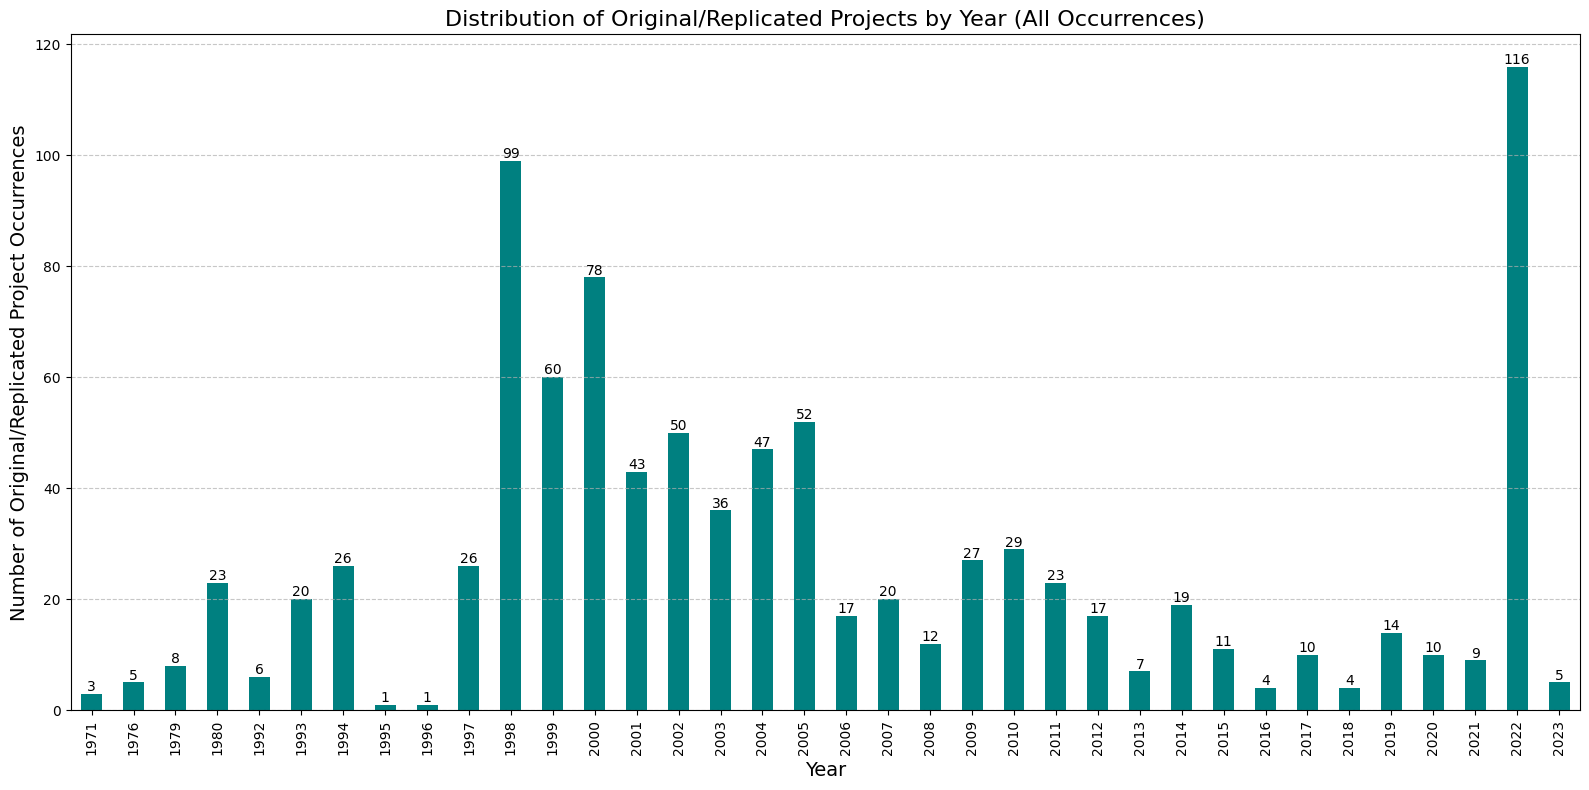

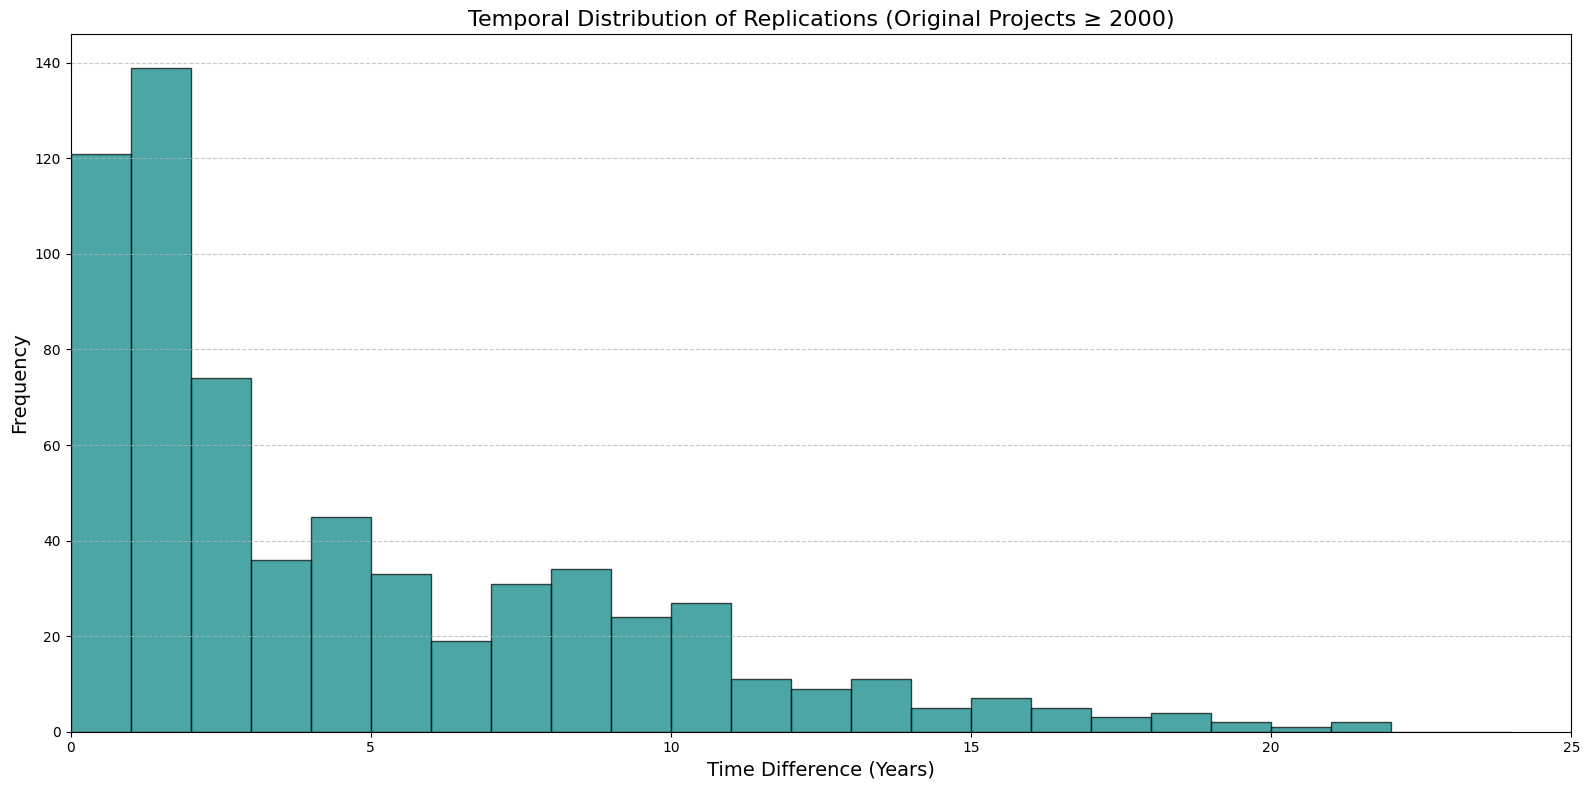

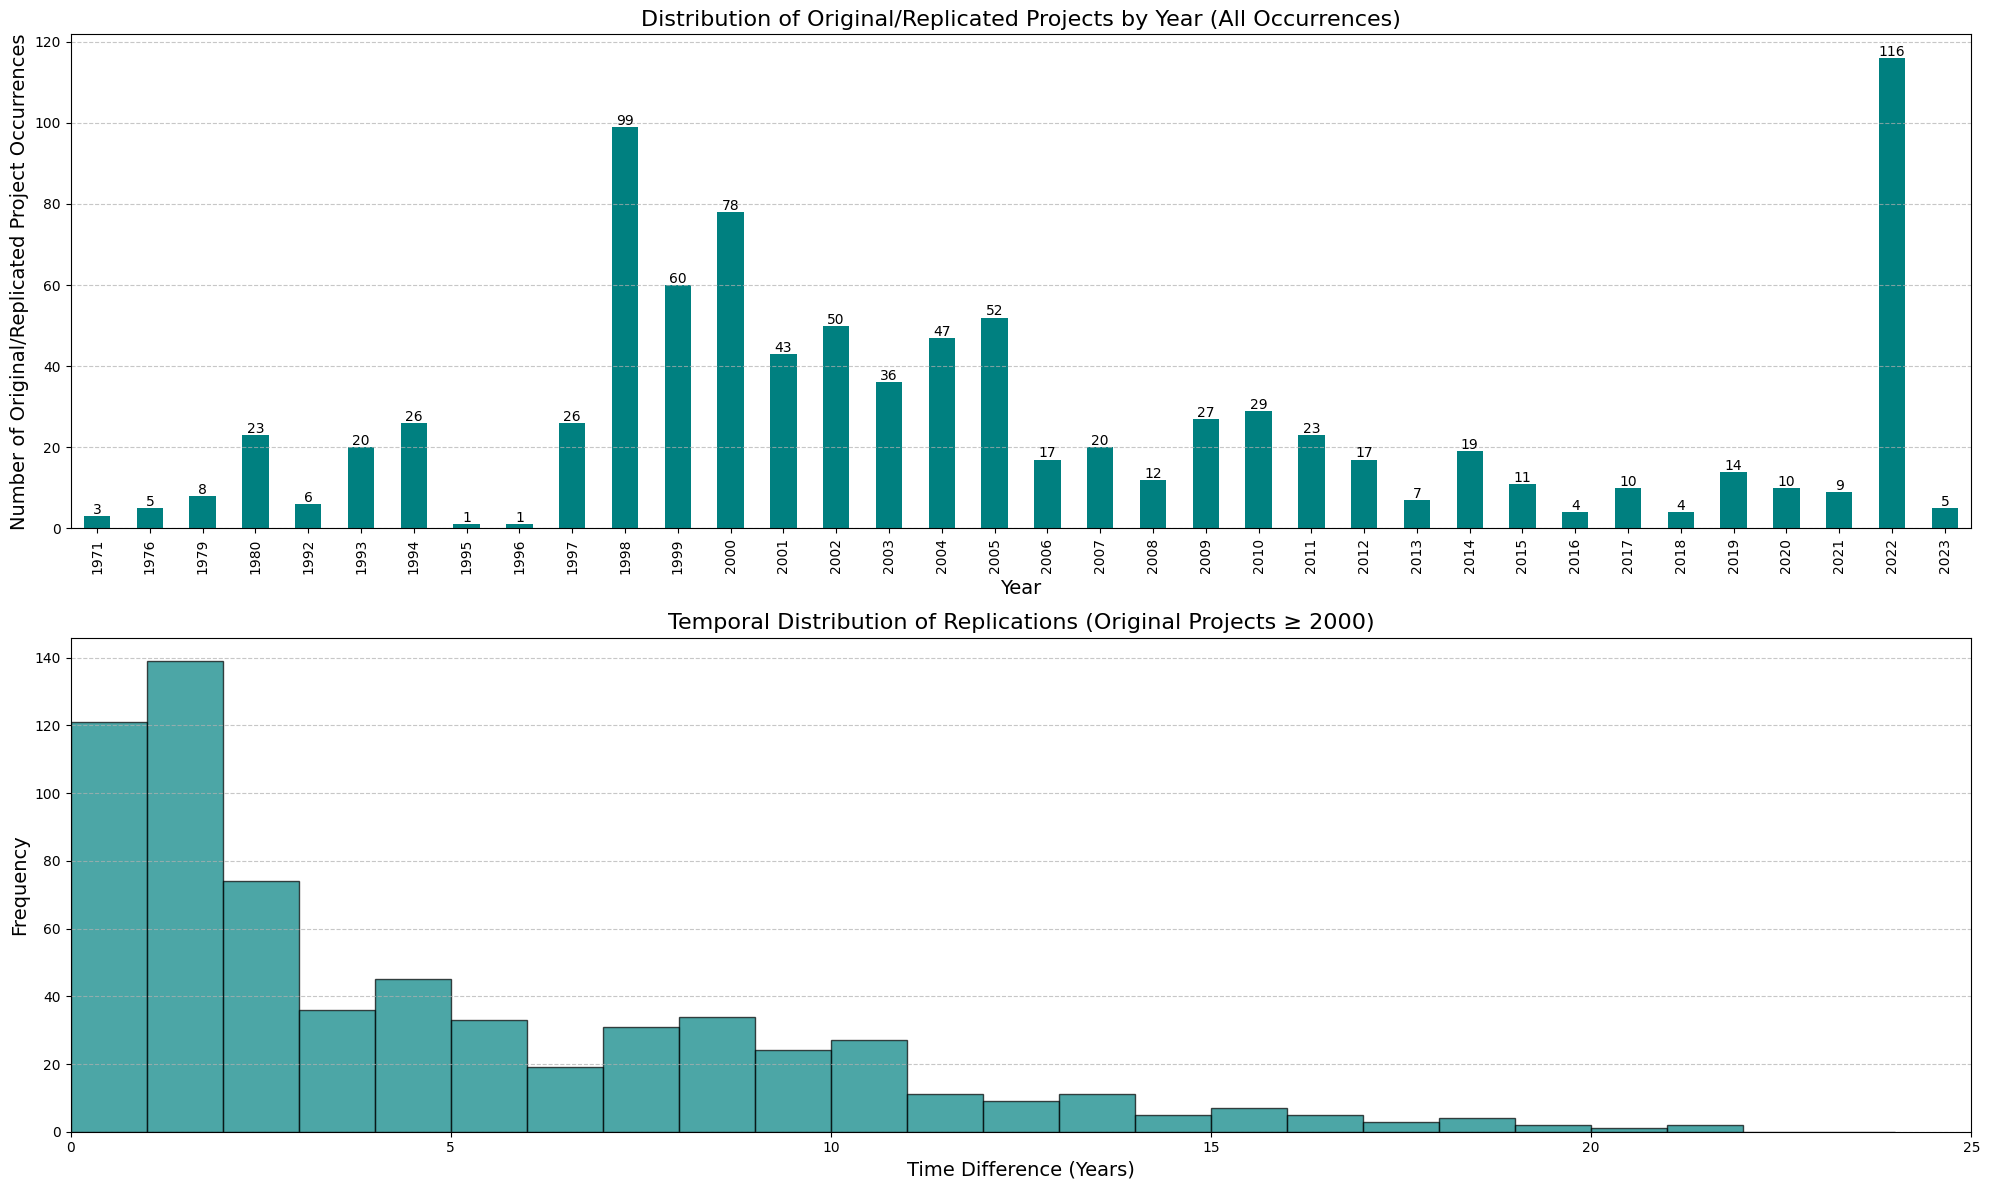

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

def analyze_original_projects_distribution(file_path):
    """
    Analyze the distribution of original/replicated projects by year and time differences.
    Consider all occurrences of Original/Replicated in both category columns.
    
    Args:
        file_path: Path to the merged dataset CSV file
    """
    # Load the merged dataset
    print(f"Loading merged dataset from: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} replication pairs")
    
    # Create a list to store all instances of original projects with their dates
    original_records = []
    
    # Extract all original projects from category_1 with their dates
    if 'category_1' in df.columns and 'document_id_1' in df.columns and 'project_date_1' in df.columns:
        orig_df_1 = df[df['category_1'] == 'Original/Replicated']
        print(f"Found {len(orig_df_1)} occurrences of Original/Replicated in category_1")
        
        for _, row in orig_df_1.iterrows():
            if pd.notna(row['project_date_1']):
                original_records.append({
                    'project_id': row['document_id_1'],
                    'date': row['project_date_1']
                })
    
    # Extract all original projects from category_2 with their dates
    if 'category_2' in df.columns and 'document_id_2' in df.columns and 'project_date_2' in df.columns:
        orig_df_2 = df[df['category_2'] == 'Original/Replicated']
        print(f"Found {len(orig_df_2)} occurrences of Original/Replicated in category_2")
        
        for _, row in orig_df_2.iterrows():
            if pd.notna(row['project_date_2']):
                original_records.append({
                    'project_id': row['document_id_2'],
                    'date': row['project_date_2']
                })
    
    print(f"Total occurrences of Original/Replicated projects: {len(original_records)}")
    
    # Create DataFrame of all original project occurrences
    all_originals_df = pd.DataFrame(original_records)
    print(f"Created dataset with {len(all_originals_df)} Original/Replicated project occurrences")
    
    # Count unique project IDs among originals
    unique_original_projects = all_originals_df['project_id'].nunique()
    print(f"Number of unique Original/Replicated projects: {unique_original_projects}")
    
    # Convert dates to datetime
    all_originals_df['date'] = pd.to_datetime(all_originals_df['date'])
    
    # Extract year
    all_originals_df['year'] = all_originals_df['date'].dt.year
    
    # 1. Analysis 1: Distribution of original projects by year
    plt.figure(figsize=(16, 8))
    
    # Count original project occurrences by year
    year_counts = all_originals_df['year'].value_counts().sort_index()
    
    # Plot the distribution
    ax = year_counts.plot(kind='bar', color='teal')
    
    plt.title('Distribution of Original/Replicated Projects by Year (All Occurrences)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Original/Replicated Project Occurrences', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of bars
    for i, count in enumerate(year_counts):
        ax.text(i, count + 0.5, str(count), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('original_projects_by_year_all_occurrences.png', dpi=300)
    print("Saved distribution by year to 'original_projects_by_year_all_occurrences.png'")
    
    # 2. Analysis 2: Temporal distribution (time difference) for projects >=2000
    # Find all replication pairs with originals from 2000 onwards
    replication_pairs = []
    
    # Check for pairs where project 1 is original and project 2 is replicating
    orig_repl_pairs = df[(df['category_1'] == 'Original/Replicated') & 
                         (df['category_2'] == 'Replicating')]
    
    # Process those pairs
    for _, pair in orig_repl_pairs.iterrows():
        try:
            date1 = pd.to_datetime(pair['project_date_1'])
            date2 = pd.to_datetime(pair['project_date_2'])
            
            # Only include pairs where original project is from 2000 onwards
            if date1.year >= 2000:
                time_diff_years = (date2 - date1).days / 365.25
                
                # Include only valid positive time differences
                if time_diff_years > 0:
                    replication_pairs.append({
                        'original_id': pair['document_id_1'],
                        'replicating_id': pair['document_id_2'],
                        'original_date': date1,
                        'replicating_date': date2,
                        'time_diff_years': time_diff_years
                    })
        except:
            continue
    
    # Check for pairs where project 2 is original and project 1 is replicating
    repl_orig_pairs = df[(df['category_1'] == 'Replicating') & 
                         (df['category_2'] == 'Original/Replicated')]
    
    # Process those pairs
    for _, pair in repl_orig_pairs.iterrows():
        try:
            date1 = pd.to_datetime(pair['project_date_2'])
            date2 = pd.to_datetime(pair['project_date_1'])
            
            # Only include pairs where original project is from 2000 onwards
            if date1.year >= 2000:
                time_diff_years = (date2 - date1).days / 365.25
                
                # Include only valid positive time differences
                if time_diff_years > 0:
                    replication_pairs.append({
                        'original_id': pair['document_id_2'],
                        'replicating_id': pair['document_id_1'],
                        'original_date': date1,
                        'replicating_date': date2,
                        'time_diff_years': time_diff_years
                    })
        except:
            continue
    
    # Create DataFrame of replication pairs
    replication_df = pd.DataFrame(replication_pairs)
    
    print(f"Found {len(replication_df)} replication pairs with positive time differences (originals ≥ 2000)")
    
    # Plot the temporal distribution
    plt.figure(figsize=(16, 8))
    
    # Create histogram of time differences
    bins = np.arange(0, 25, 1)  # 0 to 25 years in 1-year bins
    plt.hist(replication_df['time_diff_years'], bins=bins, color='teal', edgecolor='black', alpha=0.7)
    
    plt.title('Temporal Distribution of Replications (Original Projects ≥ 2000)', fontsize=16)
    plt.xlabel('Time Difference (Years)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 25)
    
    plt.tight_layout()
    plt.savefig('replication_time_differences_corrected.png', dpi=300)
    print("Saved temporal distribution to 'replication_time_differences_corrected.png'")
    
    # Additional analysis: Statistics on time differences
    print("\nStatistics on replication time differences (in years):")
    print(f"  Mean: {replication_df['time_diff_years'].mean():.2f}")
    print(f"  Median: {replication_df['time_diff_years'].median():.2f}")
    print(f"  Standard Deviation: {replication_df['time_diff_years'].std():.2f}")
    print(f"  Minimum: {replication_df['time_diff_years'].min():.2f}")
    print(f"  Maximum: {replication_df['time_diff_years'].max():.2f}")
    
    # Count number of replication pairs by original project
    replication_counts = replication_df['original_id'].value_counts()
    print(f"\nStatistics on replications per original project:")
    print(f"  Mean: {replication_counts.mean():.2f}")
    print(f"  Median: {replication_counts.median():.2f}")
    print(f"  Maximum: {replication_counts.max()}")
    print(f"  Minimum: {replication_counts.min()}")
    
    # Create a more comprehensive visualization combining both analyses
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Distribution by Year
    plt.subplot(2, 1, 1)
    ax1 = year_counts.plot(kind='bar', color='teal')
    plt.title('Distribution of Original/Replicated Projects by Year (All Occurrences)', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Original/Replicated Project Occurrences', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add count labels on top of bars
    for i, count in enumerate(year_counts):
        ax1.text(i, count + 0.5, str(count), ha='center', fontsize=10)
    
    # Plot 2: Time Difference Distribution
    plt.subplot(2, 1, 2)
    bins = np.arange(0, 25, 1)  # 0 to 25 years in 1-year bins
    plt.hist(replication_df['time_diff_years'], bins=bins, color='teal', edgecolor='black', alpha=0.7)
    plt.title('Temporal Distribution of Replications (Original Projects ≥ 2000)', fontsize=16)
    plt.xlabel('Time Difference (Years)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 25)
    
    plt.tight_layout()
    plt.savefig('original_projects_comprehensive_analysis_corrected.png', dpi=300)
    print("Saved comprehensive analysis to 'original_projects_comprehensive_analysis_corrected.png'")
    
    return all_originals_df, replication_df

if __name__ == "__main__":
    # File path to the merged dataset
    file_path = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications_with_Categories.csv"
    
    # Run the analysis
    original_df, replication_df = analyze_original_projects_distribution(file_path)


### Orginal Project Replications

Loading merged dataset from: /Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications_with_Categories.csv
Loaded 11996 replication pairs
Found 461 replication pairs for 145 unique original projects from 1998-2005
Saved temporal distribution to 'replication_time_diff_1998_to_2005.png'

Statistics on replication time differences (in years) for originals from 1998-2005:
  Number of replication pairs: 461
  Mean: 7.50
  Median: 6.96
  Standard Deviation: 5.57
  Minimum: 0.00
  Maximum: 22.75

Distribution of original projects by year within 1998-2005:
  1998: 99 replication pairs
  1999: 59 replication pairs
  2000: 77 replication pairs
  2001: 43 replication pairs
  2002: 50 replication pairs
  2003: 36 replication pairs
  2004: 47 replication pairs
  2005: 50 replication pairs
Saved yearly breakdown to 'yearly_breakdown_1998_to_2005.png'


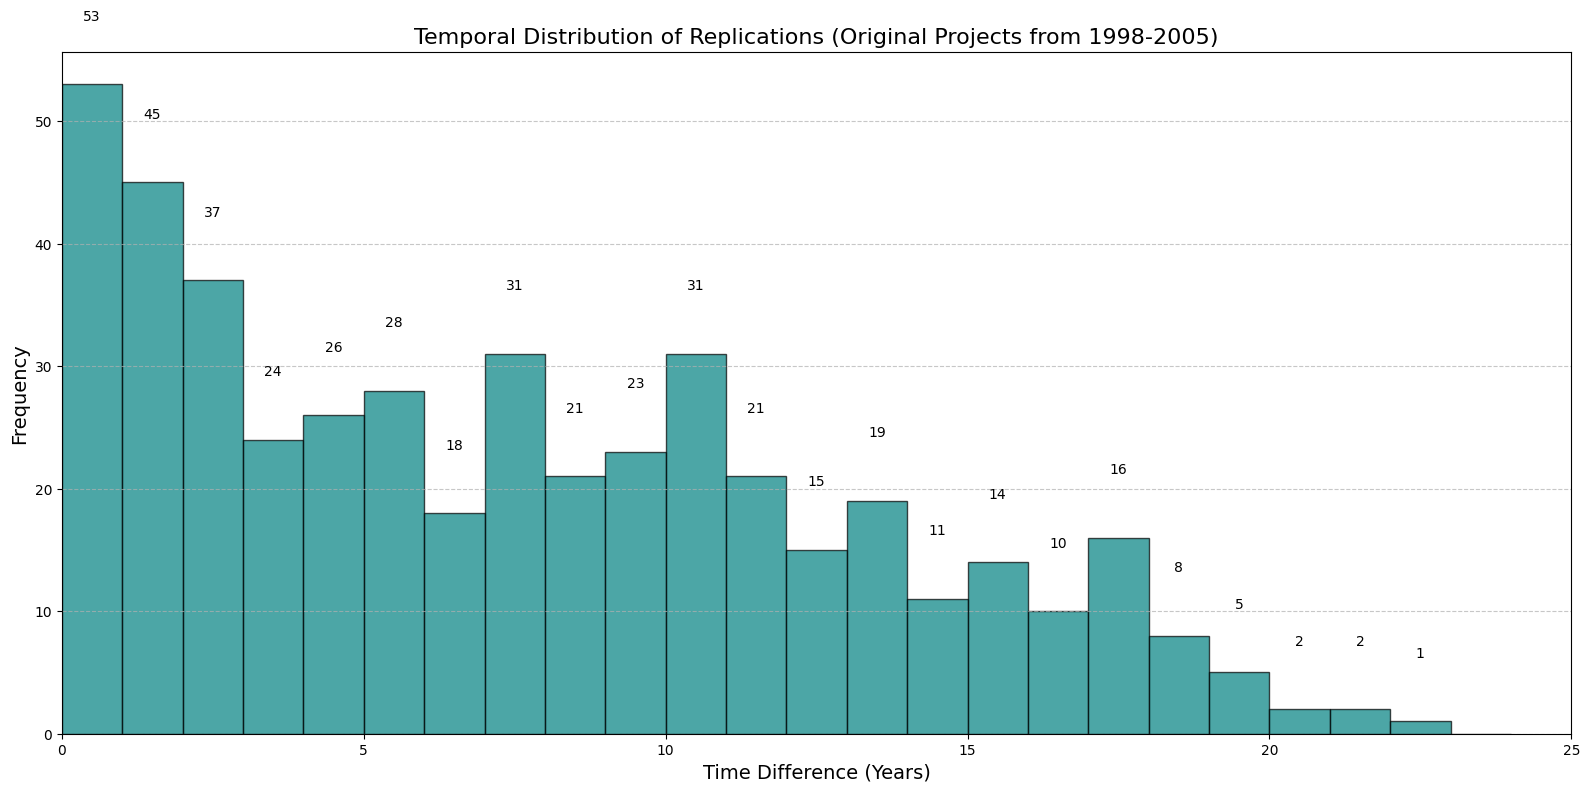

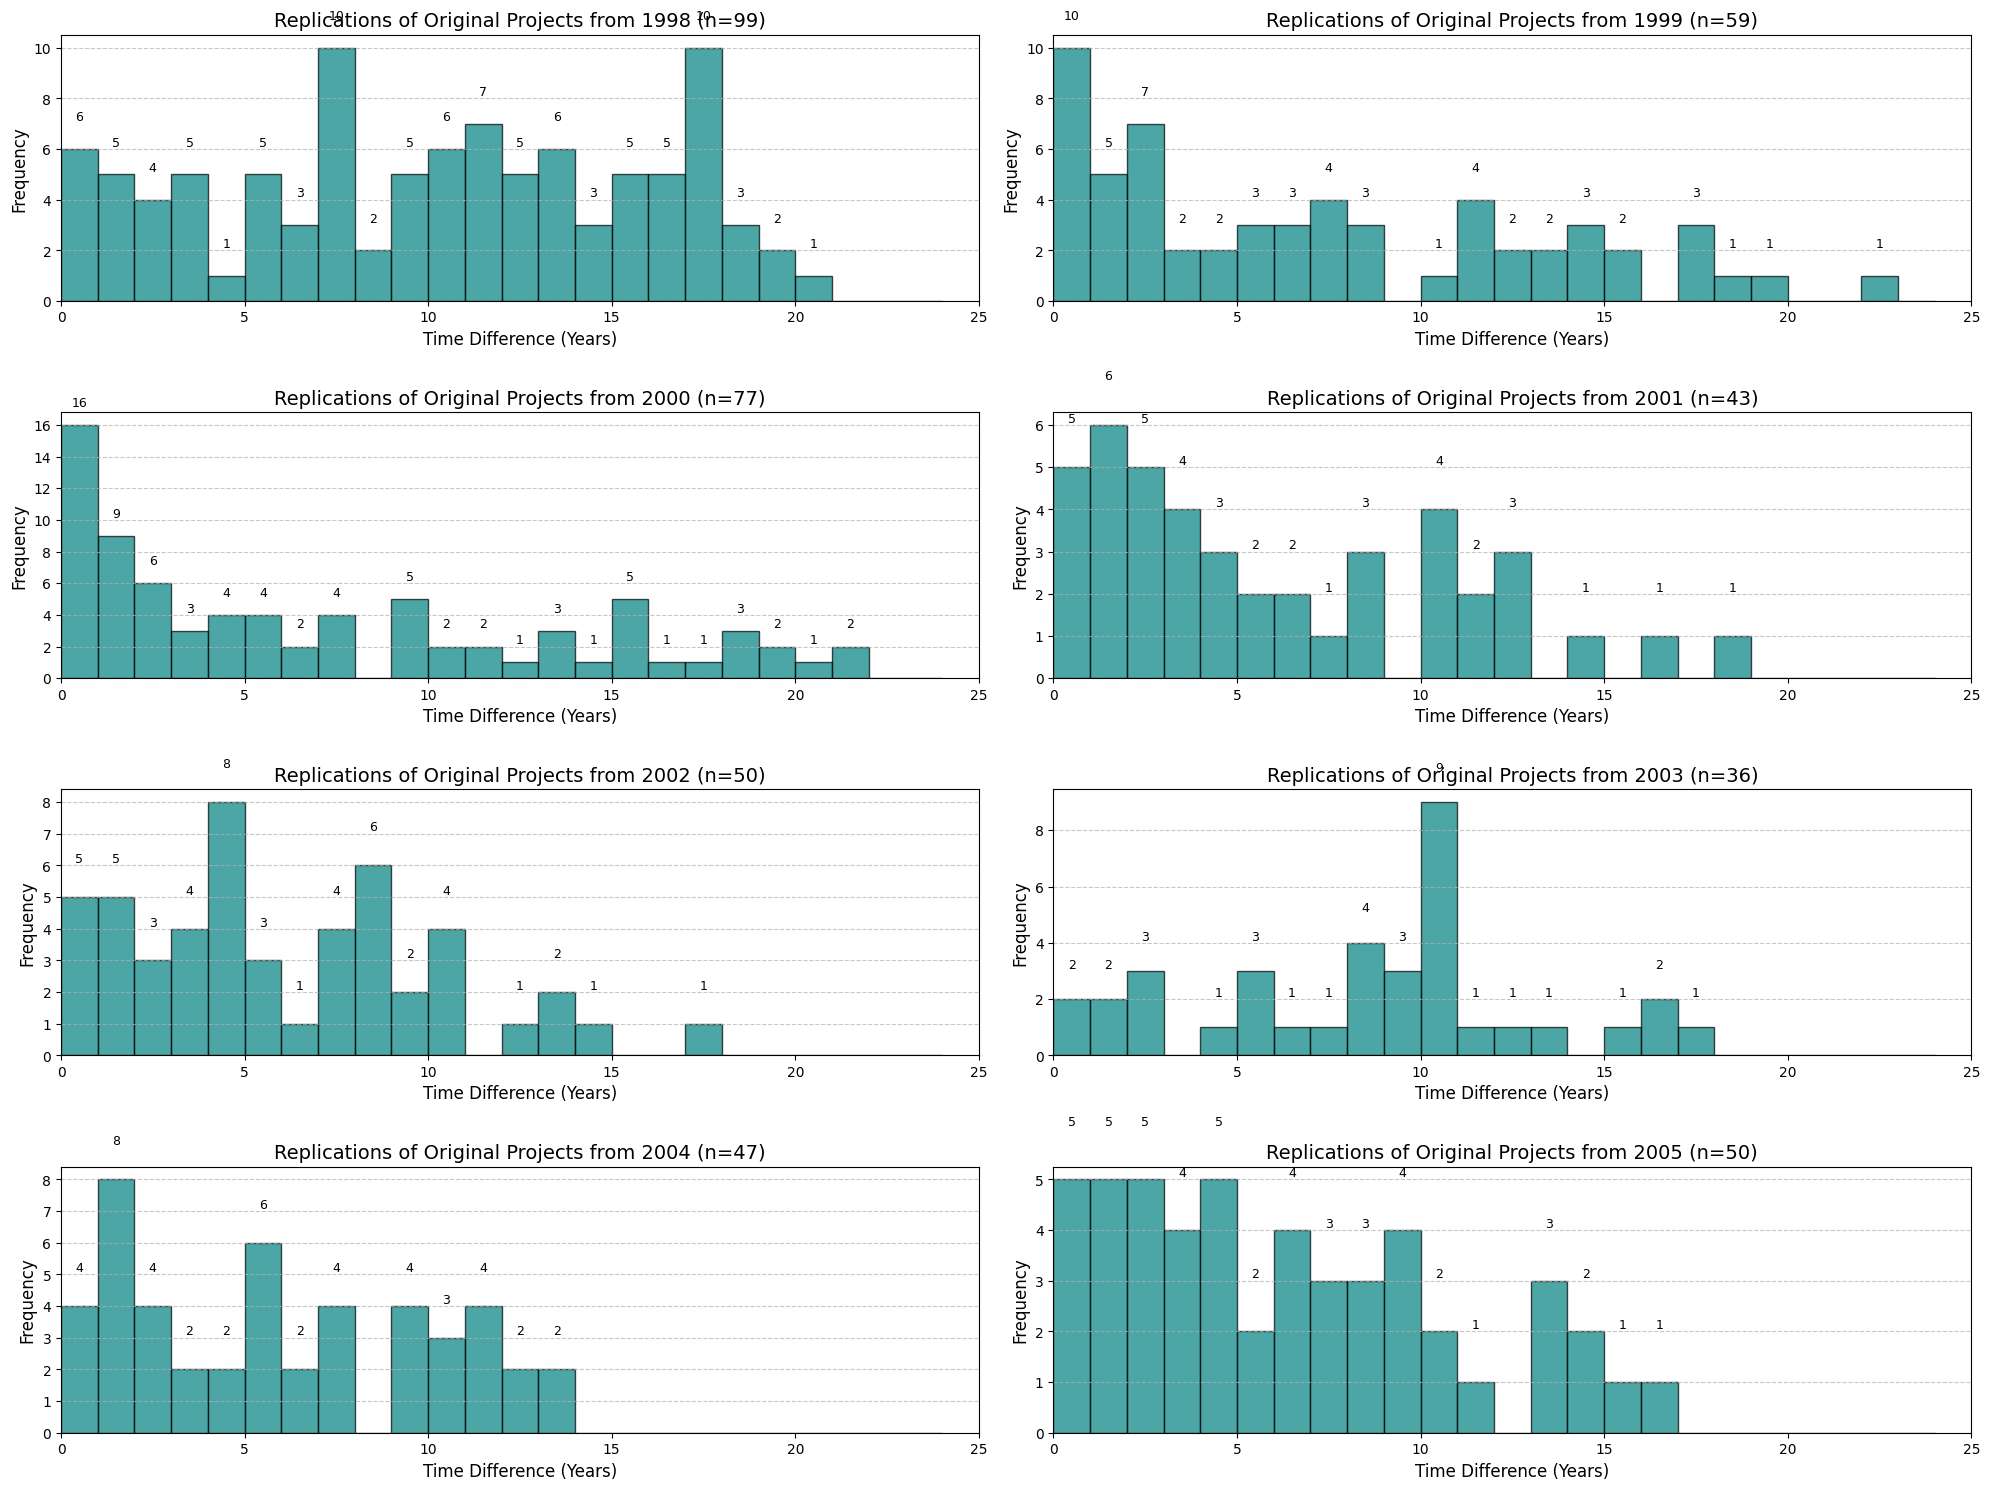

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns

def analyze_specific_years(file_path, start_year=1998, end_year=2005):
    """
    Analyze temporal distribution of replications for original projects from a specific time period.
    
    Args:
        file_path: Path to the merged dataset CSV file
        start_year: Start year for filtering original projects (inclusive)
        end_year: End year for filtering original projects (inclusive)
    """
    # Load the merged dataset
    print(f"Loading merged dataset from: {file_path}")
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} replication pairs")
    
    # Find all replication pairs for originals from the specified year range
    replication_pairs = []
    
    # Check for pairs where project 1 is original and project 2 is replicating
    orig_repl_pairs = df[(df['category_1'] == 'Original/Replicated') & 
                         (df['category_2'] == 'Replicating')]
    
    # Process those pairs
    for _, pair in orig_repl_pairs.iterrows():
        try:
            date1 = pd.to_datetime(pair['project_date_1'])
            date2 = pd.to_datetime(pair['project_date_2'])
            
            # Only include pairs where original project is from the specified year range
            if start_year <= date1.year <= end_year:
                time_diff_years = (date2 - date1).days / 365.25
                
                # Include only valid positive time differences
                if time_diff_years > 0:
                    replication_pairs.append({
                        'original_id': pair['document_id_1'],
                        'replicating_id': pair['document_id_2'],
                        'original_date': date1,
                        'replicating_date': date2,
                        'time_diff_years': time_diff_years,
                        'original_year': date1.year
                    })
        except:
            continue
    
    # Check for pairs where project 2 is original and project 1 is replicating
    repl_orig_pairs = df[(df['category_1'] == 'Replicating') & 
                         (df['category_2'] == 'Original/Replicated')]
    
    # Process those pairs
    for _, pair in repl_orig_pairs.iterrows():
        try:
            date1 = pd.to_datetime(pair['project_date_2'])
            date2 = pd.to_datetime(pair['project_date_1'])
            
            # Only include pairs where original project is from the specified year range
            if start_year <= date1.year <= end_year:
                time_diff_years = (date2 - date1).days / 365.25
                
                # Include only valid positive time differences
                if time_diff_years > 0:
                    replication_pairs.append({
                        'original_id': pair['document_id_2'],
                        'replicating_id': pair['document_id_1'],
                        'original_date': date1,
                        'replicating_date': date2,
                        'time_diff_years': time_diff_years,
                        'original_year': date1.year
                    })
        except:
            continue
    
    # Create DataFrame of replication pairs
    replication_df = pd.DataFrame(replication_pairs)
    
    # Count unique original projects
    unique_originals_count = replication_df['original_id'].nunique()
    
    print(f"Found {len(replication_df)} replication pairs for {unique_originals_count} unique original projects from {start_year}-{end_year}")
    
    # Plot the temporal distribution for 1998-2005 originals
    plt.figure(figsize=(16, 8))
    
    # Create histogram of time differences
    bins = np.arange(0, 25, 1)  # 0 to 25 years in 1-year bins
    counts, edges, bars = plt.hist(replication_df['time_diff_years'], bins=bins, 
                                  color='teal', edgecolor='black', alpha=0.7)
    
    # Add count labels above bars
    for i, count in enumerate(counts):
        if count > 0:  # Only add label if the bar has a non-zero value
            plt.text(edges[i] + 0.5, count + 5, str(int(count)), 
                     ha='center', va='bottom', fontsize=10)
    
    plt.title(f'Temporal Distribution of Replications (Original Projects from {start_year}-{end_year})', fontsize=16)
    plt.xlabel('Time Difference (Years)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 25)
    
    plt.tight_layout()
    output_file = f'replication_time_diff_{start_year}_to_{end_year}.png'
    plt.savefig(output_file, dpi=300)
    print(f"Saved temporal distribution to '{output_file}'")
    
    # Additional analysis: Statistics on time differences
    print(f"\nStatistics on replication time differences (in years) for originals from {start_year}-{end_year}:")
    print(f"  Number of replication pairs: {len(replication_df)}")
    print(f"  Mean: {replication_df['time_diff_years'].mean():.2f}")
    print(f"  Median: {replication_df['time_diff_years'].median():.2f}")
    print(f"  Standard Deviation: {replication_df['time_diff_years'].std():.2f}")
    print(f"  Minimum: {replication_df['time_diff_years'].min():.2f}")
    print(f"  Maximum: {replication_df['time_diff_years'].max():.2f}")
    
    # Distribution of original projects by year within the range
    year_counts = replication_df['original_year'].value_counts().sort_index()
    print(f"\nDistribution of original projects by year within {start_year}-{end_year}:")
    for year, count in year_counts.items():
        print(f"  {year}: {count} replication pairs")
    
    # Also create a breakdown by year
    plt.figure(figsize=(20, 15))
    
    # Create a 4x2 grid of subplots for each year
    year_range = range(start_year, end_year + 1)
    
    # Calculate number of rows needed (2 plots per row)
    n_rows = (len(year_range) + 1) // 2
    
    for i, year in enumerate(year_range):
        # Filter data for this specific year
        year_data = replication_df[replication_df['original_year'] == year]
        
        # Skip if no data for this year
        if len(year_data) == 0:
            continue
        
        # Create subplot
        plt.subplot(n_rows, 2, i + 1)
        
        # Create histogram
        counts, edges, bars = plt.hist(year_data['time_diff_years'], bins=bins, 
                                      color='teal', edgecolor='black', alpha=0.7)
        
        # Add count labels above bars
        for j, count in enumerate(counts):
            if count > 0:  # Only add label if the bar has a non-zero value
                plt.text(edges[j] + 0.5, count + 1, str(int(count)), 
                         ha='center', va='bottom', fontsize=9)
        
        plt.title(f'Replications of Original Projects from {year} (n={len(year_data)})', fontsize=14)
        plt.xlabel('Time Difference (Years)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.xlim(0, 25)
    
    plt.tight_layout()
    breakdown_file = f'yearly_breakdown_{start_year}_to_{end_year}.png'
    plt.savefig(breakdown_file, dpi=300)
    print(f"Saved yearly breakdown to '{breakdown_file}'")
    
    return replication_df

if __name__ == "__main__":
    # File path to the merged dataset
    file_path = "/Users/munibqasim/Desktop/Munib Qasim Zia/World Bank/2025 FY/Thomas Team/Codes/Analysis/Munib Data/Similar Project Latest Run/analysis_20250414_154948/WorldBank_analysis/WorldBank_Replications_with_Categories.csv"
    
    # Run the analysis for 1998-2005
    replication_df = analyze_specific_years(file_path, 1998, 2005)